# Amazon Fine Food Reviews Analysis


Data Source: https://www.kaggle.com/snap/amazon-fine-food-reviews <br>

EDA: https://nycdatascience.com/blog/student-works/amazon-fine-foods-visualization/


The Amazon Fine Food Reviews dataset consists of reviews of fine foods from Amazon.<br>

Number of reviews: 568,454<br>
Number of users: 256,059<br>
Number of products: 74,258<br>
Timespan: Oct 1999 - Oct 2012<br>
Number of Attributes/Columns in data: 10 

Attribute Information:

1. Id
2. ProductId - unique identifier for the product
3. UserId - unqiue identifier for the user
4. ProfileName
5. HelpfulnessNumerator - number of users who found the review helpful
6. HelpfulnessDenominator - number of users who indicated whether they found the review helpful or not
7. Score - rating between 1 and 5
8. Time - timestamp for the review
9. Summary - brief summary of the review
10. Text - text of the review


#### Objective:
Given a review, determine whether the review is positive (rating of 4 or 5) or negative (rating of 1 or 2).

<br>
[Q] How to determine if a review is positive or negative?<br>
<br> 
[Ans] We could use Score/Rating. A rating of 4 or 5 can be cosnidered as a positive review. A rating of 1 or 2 can be considered as negative one. A review of rating 3 is considered nuetral and such reviews are ignored from our analysis. This is an approximate and proxy way of determining the polarity (positivity/negativity) of a review.




# [1]. Reading Data

## [1.1] Loading the data

The dataset is available in two forms
1. .csv file
2. SQLite Database

In order to load the data, We have used the SQLITE dataset as it is easier to query the data and visualise the data efficiently.
<br> 

Here as we only want to get the global sentiment of the recommendations (positive or negative), we will purposefully ignore all Scores equal to 3. If the score is above 3, then the recommendation wil be set to "positive". Otherwise, it will be set to "negative".

In [1]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")


import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer

import re
# Tutorial about Python regular expressions: https://pymotw.com/2/re/
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle

from tqdm import tqdm
import os

# Install prettytable
import sys
!{sys.executable} -m pip install https://pypi.python.org/packages/source/P/PrettyTable/prettytable-0.7.2.tar.bz2


  Using cached prettytable-0.7.2.tar.bz2
  Running setup.py bdist_wheel for prettytable: started
  Running setup.py bdist_wheel for prettytable: finished with status 'done'
  Stored in directory: C:\Users\Vijay Joseph\AppData\Local\pip\Cache\wheels\29\73\c9\3e063a66859af18585f8e1439f92dcc27b8c13ae400bb8c89e
Successfully built prettytable


You are using pip version 9.0.1, however version 19.0.1 is available.
You should consider upgrading via the 'python -m pip install --upgrade pip' command.


In [2]:
# using SQLite Table to read data.
con = sqlite3.connect('database.sqlite') 

# filtering only positive and negative reviews i.e. 
# not taking into consideration those reviews with Score=3
# SELECT * FROM Reviews WHERE Score != 3 LIMIT 500000, will give top 500000 data points
# you can change the number to any other number based on your computing power

# filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 LIMIT 500000""", con) 
# for tsne assignment you can take 5k data points

filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 """, con) 

# Give reviews with Score>3 a positive rating(1), and reviews with a score<3 a negative rating(0).
def partition(x):
    if x < 3:
        return 0
    return 1

#changing reviews with score less than 3 to be positive and vice-versa
actualScore = filtered_data['Score']
positiveNegative = actualScore.map(partition) 
filtered_data['Score'] = positiveNegative
print("Number of data points in our data", filtered_data.shape)
filtered_data.head(3)

Number of data points in our data (525814, 10)


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,1,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,0,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,1,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...


In [3]:
display = pd.read_sql_query("""
SELECT UserId, ProductId, ProfileName, Time, Score, Text, COUNT(*)
FROM Reviews
GROUP BY UserId
HAVING COUNT(*)>1
""", con)

In [4]:
print(display.shape)
display.head()

(80668, 7)


,UserId,ProductId,ProfileName,Time,Score,Text,COUNT(*)
0,#oc-R115TNMSPFT9I7,B007Y59HVM,Breyton,1331510400,2,Overall its just OK when considering the price...,2
1,#oc-R11D9D7SHXIJB9,B005HG9ET0,"Louis E. Emory ""hoppy""",1342396800,5,"My wife has recurring extreme muscle spasms, u...",3
2,#oc-R11DNU2NBKQ23Z,B007Y59HVM,Kim Cieszykowski,1348531200,1,This coffee is horrible and unfortunately not ...,2
3,#oc-R11O5J5ZVQE25C,B005HG9ET0,Penguin Chick,1346889600,5,This will be the bottle that you grab from the...,3
4,#oc-R12KPBODL2B5ZD,B007OSBE1U,Christopher P. Presta,1348617600,1,I didnt like this coffee. Instead of telling y...,2


In [5]:
display[display['UserId']=='AZY10LLTJ71NX']

,UserId,ProductId,ProfileName,Time,Score,Text,COUNT(*)
80638,AZY10LLTJ71NX,B006P7E5ZI,"undertheshrine ""undertheshrine""",1334707200,5,I was recommended to try green tea extract to ...,5


In [6]:
display['COUNT(*)'].sum()

393063

#  [2] Exploratory Data Analysis

## [2.1] Data Cleaning: Deduplication

It is observed (as shown in the table below) that the reviews data had many duplicate entries. Hence it was necessary to remove duplicates in order to get unbiased results for the analysis of the data.  Following is an example:

In [7]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND UserId="AR5J8UI46CURR"
ORDER BY ProductID
""", con)
display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,78445,B000HDL1RQ,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
1,138317,B000HDOPYC,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
2,138277,B000HDOPYM,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
3,73791,B000HDOPZG,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
4,155049,B000PAQ75C,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...


As it can be seen above that same user has multiple reviews with same values for HelpfulnessNumerator, HelpfulnessDenominator, Score, Time, Summary and Text and on doing analysis it was found that <br>
<br> 
ProductId=B000HDOPZG was Loacker Quadratini Vanilla Wafer Cookies, 8.82-Ounce Packages (Pack of 8)<br>
<br> 
ProductId=B000HDL1RQ was Loacker Quadratini Lemon Wafer Cookies, 8.82-Ounce Packages (Pack of 8) and so on<br>

It was inferred after analysis that reviews with same parameters other than ProductId belonged to the same product just having different flavour or quantity. Hence in order to reduce redundancy it was decided to eliminate the rows having same parameters.<br>

The method used for the same was that we first sort the data according to ProductId and then just keep the first similar product review and delelte the others. for eg. in the above just the review for ProductId=B000HDL1RQ remains. This method ensures that there is only one representative for each product and deduplication without sorting would lead to possibility of different representatives still existing for the same product.

In [8]:
#Sorting data according to ProductId in ascending order
sorted_data=filtered_data.sort_values('ProductId', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')

In [9]:
#Deduplication of entries
final=sorted_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"}, keep='first', inplace=False)
final.shape

(364173, 10)

In [10]:
#Checking to see how much % of data still remains
(final['Id'].size*1.0)/(filtered_data['Id'].size*1.0)*100

69.25890143662969

<b>Observation:-</b> It was also seen that in two rows given below the value of HelpfulnessNumerator is greater than HelpfulnessDenominator which is not practically possible hence these two rows too are removed from calcualtions

In [11]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND Id=44737 OR Id=64422
ORDER BY ProductID
""", con)

display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,64422,B000MIDROQ,A161DK06JJMCYF,"J. E. Stephens ""Jeanne""",3,1,5,1224892800,Bought This for My Son at College,My son loves spaghetti so I didn't hesitate or...
1,44737,B001EQ55RW,A2V0I904FH7ABY,Ram,3,2,4,1212883200,Pure cocoa taste with crunchy almonds inside,It was almost a 'love at first bite' - the per...


In [12]:
final=final[final.HelpfulnessNumerator<=final.HelpfulnessDenominator]

In [13]:
#Before starting the next phase of preprocessing lets see the number of entries left
print(final.shape)

#How many positive and negative reviews are present in our dataset?
final['Score'].value_counts()

(364171, 10)


1    307061
0     57110
Name: Score, dtype: int64

#  [3] Preprocessing

## [3.1].  Preprocessing Review Text

Now that we have finished deduplication our data requires some preprocessing before we go on further with analysis and making the prediction model.

Hence in the Preprocessing phase we do the following in the order below:-

1. Begin by removing the html tags
2. Remove any punctuations or limited set of special characters like , or . or # etc.
3. Check if the word is made up of english letters and is not alpha-numeric
4. Check to see if the length of the word is greater than 2 (as it was researched that there is no adjective in 2-letters)
5. Convert the word to lowercase
6. Remove Stopwords
7. Finally Snowball Stemming the word (it was obsereved to be better than Porter Stemming)<br>

After which we collect the words used to describe positive and negative reviews

In [14]:
"""

# printing some random reviews
sent_0 = final['Text'].values[0]
print(sent_0)
print("="*50)

sent_1000 = final['Text'].values[1000]
print(sent_1000)
print("="*50)

sent_1500 = final['Text'].values[1500]
print(sent_1500)
print("="*50)

sent_4900 = final['Text'].values[4900]
print(sent_4900)
print("="*50)

"""

'\n\n# printing some random reviews\nsent_0 = final[\'Text\'].values[0]\nprint(sent_0)\nprint("="*50)\n\nsent_1000 = final[\'Text\'].values[1000]\nprint(sent_1000)\nprint("="*50)\n\nsent_1500 = final[\'Text\'].values[1500]\nprint(sent_1500)\nprint("="*50)\n\nsent_4900 = final[\'Text\'].values[4900]\nprint(sent_4900)\nprint("="*50)\n\n'

In [15]:
"""

# remove urls from text python: https://stackoverflow.com/a/40823105/4084039
sent_0 = re.sub(r"http\S+", "", sent_0)
sent_1000 = re.sub(r"http\S+", "", sent_1000)
sent_150 = re.sub(r"http\S+", "", sent_1500)
sent_4900 = re.sub(r"http\S+", "", sent_4900)

print(sent_0)

"""

'\n\n# remove urls from text python: https://stackoverflow.com/a/40823105/4084039\nsent_0 = re.sub(r"http\\S+", "", sent_0)\nsent_1000 = re.sub(r"http\\S+", "", sent_1000)\nsent_150 = re.sub(r"http\\S+", "", sent_1500)\nsent_4900 = re.sub(r"http\\S+", "", sent_4900)\n\nprint(sent_0)\n\n'

In [16]:
"""

# https://stackoverflow.com/questions/16206380/python-beautifulsoup-how-to-remove-all-tags-from-an-element
from bs4 import BeautifulSoup

soup = BeautifulSoup(sent_0, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_1000, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_1500, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_4900, 'lxml')
text = soup.get_text()
print(text)

"""

'\n\n# https://stackoverflow.com/questions/16206380/python-beautifulsoup-how-to-remove-all-tags-from-an-element\nfrom bs4 import BeautifulSoup\n\nsoup = BeautifulSoup(sent_0, \'lxml\')\ntext = soup.get_text()\nprint(text)\nprint("="*50)\n\nsoup = BeautifulSoup(sent_1000, \'lxml\')\ntext = soup.get_text()\nprint(text)\nprint("="*50)\n\nsoup = BeautifulSoup(sent_1500, \'lxml\')\ntext = soup.get_text()\nprint(text)\nprint("="*50)\n\nsoup = BeautifulSoup(sent_4900, \'lxml\')\ntext = soup.get_text()\nprint(text)\n\n'

In [17]:
# https://stackoverflow.com/a/47091490/4084039
import re

def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

In [18]:
"""

sent_1500 = decontracted(sent_1500)
print(sent_1500)
print("="*50)

"""

'\n\nsent_1500 = decontracted(sent_1500)\nprint(sent_1500)\nprint("="*50)\n\n'

In [19]:
"""

#remove words with numbers python: https://stackoverflow.com/a/18082370/4084039
sent_0 = re.sub("\S*\d\S*", "", sent_0).strip()
print(sent_0)

"""

'\n\n#remove words with numbers python: https://stackoverflow.com/a/18082370/4084039\nsent_0 = re.sub("\\S*\\d\\S*", "", sent_0).strip()\nprint(sent_0)\n\n'

In [20]:
"""

#remove spacial character: https://stackoverflow.com/a/5843547/4084039
sent_1500 = re.sub('[^A-Za-z0-9]+', ' ', sent_1500)
print(sent_1500)

"""

"\n\n#remove spacial character: https://stackoverflow.com/a/5843547/4084039\nsent_1500 = re.sub('[^A-Za-z0-9]+', ' ', sent_1500)\nprint(sent_1500)\n\n"

In [21]:
# https://gist.github.com/sebleier/554280
# we are removing the words from the stop words list: 'no', 'nor', 'not'
# <br /><br /> ==> after the above steps, we are getting "br br"
# we are including them into stop words list
# instead of <br /> if we have <br/> these tags would have revmoved in the 1st step

# While using TFIDF-AvgWord2Vec vectorizer, getting error with reviews having single alphabet
# like 'k','h', .... So we are including all single alphabets in the stopwords.

stopwords= set(['br', 'the', 'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't", \
            'a','b','c','d','e','f','g','h','i','j','k','l','m','n','o','p','q','r','s','t','u','v','w','x','y','z'])

In [22]:
# Combining all the above students 
from bs4 import BeautifulSoup
from tqdm import tqdm
preprocessed_reviews = []
# tqdm is for printing the status bar
for sentence in tqdm(final['Text'].values):
    sentence = re.sub(r"http\S+", "", sentence)
    sentence = BeautifulSoup(sentence, 'lxml').get_text()
    sentence = decontracted(sentence)
    sentence = re.sub("\S*\d\S*", "", sentence).strip()
    #sentence = re.sub('[^A-Za-z]+', ' ', sentence)
    sentence = re.sub('[^A-Za-z0-9]+',' ',sentence)         #remove special characters.
    # https://gist.github.com/sebleier/554280
    sentence = ' '.join(e.lower() for e in sentence.split() if e.lower() not in stopwords)
    preprocessed_reviews.append(sentence.strip())

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 364171/364171 [04:09<00:00, 1456.77it/s]


In [23]:
# Add the preprocessed reviews to the dataframe as a new column.

# adding a column "CleanedText" to the final cleaned dataset that displays the data after 
# pre-processing of the review. 
final['CleanedReviewText']=''
final['CleanedReviewText']=preprocessed_reviews 
final[['Text','CleanedReviewText']].head()

,Text,CleanedReviewText
138706,this witty little book makes my son laugh at l...,witty little book makes son laugh loud recite ...
138688,"I grew up reading these Sendak books, and watc...",grew reading sendak books watching really rosi...
138689,This is a fun way for children to learn their ...,fun way children learn months year learn poems...
138690,This is a great little book to read aloud- it ...,great little book read aloud nice rhythm well ...
138691,This is a book of poetry about the months of t...,book poetry months year goes month cute little...


<h2><font color='red'>[3.2] Preprocessing Review Summary</font></h2>

In [24]:
## Similartly you can do preprocessing for review summary also.
# Combining all the above statements 
from bs4 import BeautifulSoup
from tqdm import tqdm
preprocessed_summary = []
# tqdm is for printing the status bar
for sentence in tqdm(final['Summary'].values):
    sentence = re.sub(r"http\S+", "", sentence)             #remove html tags
    sentence = BeautifulSoup(sentence, 'lxml').get_text()   #remove all tags from an element
    sentence = decontracted(sentence)                       #expand shortform words Ex: don't ==> do not 
    sentence = re.sub("\S*\d\S*", "", sentence).strip()     #remove words with numbers
    #sentence = re.sub('[^A-Za-z]+', ' ', sentence)         
    sentence = re.sub('[^A-Za-z0-9]+',' ',sentence)         #remove special characters.
    # https://gist.github.com/sebleier/554280
    sentence = ' '.join(e.lower() for e in sentence.split() if e.lower() not in stopwords)
    preprocessed_summary.append(sentence.strip())

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 364171/364171 [03:23<00:00, 1786.91it/s]


In [25]:
# Add the preprocessed summary to the dataframe as a new column.

# adding a column "CleanedText" to the final cleaned dataset that displays the data after 
# pre-processing of the review. 
final['CleanedSummaryText']=preprocessed_summary 
final[['Summary','CleanedSummaryText']].head()

,Summary,CleanedSummaryText
138706,EVERY book is educational,every book educational
138688,"Love the book, miss the hard cover version",love book miss hard cover version
138689,chicken soup with rice months,chicken soup rice months
138690,a good swingy rhythm for reading aloud,good swingy rhythm reading aloud
138691,A great way to learn the months,great way learn months


In [26]:
## Enrich each review comment with the summary comments.
final['CleanedReviewSummaryText'] = ''
final['CleanedReviewSummaryText'] = final['CleanedReviewText'] + final['CleanedSummaryText']

#### Use PrettyTable for summarizing results.

In [27]:
# Load the prettytable
from prettytable import PrettyTable

# Instantiate the prettytable module.
# Table to summarize our final conclusion.
summaryTable = PrettyTable()
# Set the column names for the table.
summaryTable.field_names = ["Text-VectorizationType","Hyper-Paramter(Depth)","Hyper-Paramter(MinSampleSplit)","Performance Metric", "Value"]


# [4] Featurization

## [4.1] BAG OF WORDS

In [28]:
"""

#BoW
count_vect = CountVectorizer() #in scikit-learn
count_vect.fit(preprocessed_reviews)
print("some feature names ", count_vect.get_feature_names()[:10])
print('='*50)

final_counts = count_vect.transform(preprocessed_reviews)
print("the type of count vectorizer ",type(final_counts))
print("the shape of out text BOW vectorizer ",final_counts.get_shape())
print("the number of unique words ", final_counts.get_shape()[1])

"""

'\n\n#BoW\ncount_vect = CountVectorizer() #in scikit-learn\ncount_vect.fit(preprocessed_reviews)\nprint("some feature names ", count_vect.get_feature_names()[:10])\nprint(\'=\'*50)\n\nfinal_counts = count_vect.transform(preprocessed_reviews)\nprint("the type of count vectorizer ",type(final_counts))\nprint("the shape of out text BOW vectorizer ",final_counts.get_shape())\nprint("the number of unique words ", final_counts.get_shape()[1])\n\n'

## [4.2] Bi-Grams and n-Grams.

In [29]:
"""

#bi-gram, tri-gram and n-gram

#removing stop words like "not" should be avoided before building n-grams
# count_vect = CountVectorizer(ngram_range=(1,2))
# please do read the CountVectorizer documentation http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html

# you can choose these numebrs min_df=10, max_features=5000, of your choice
count_vect = CountVectorizer(ngram_range=(1,2), min_df=10, max_features=5000)
final_bigram_counts = count_vect.fit_transform(preprocessed_reviews)
print("the type of count vectorizer ",type(final_bigram_counts))
print("the shape of out text BOW vectorizer ",final_bigram_counts.get_shape())
print("the number of unique words including both unigrams and bigrams ", final_bigram_counts.get_shape()[1])

"""

'\n\n#bi-gram, tri-gram and n-gram\n\n#removing stop words like "not" should be avoided before building n-grams\n# count_vect = CountVectorizer(ngram_range=(1,2))\n# please do read the CountVectorizer documentation http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html\n\n# you can choose these numebrs min_df=10, max_features=5000, of your choice\ncount_vect = CountVectorizer(ngram_range=(1,2), min_df=10, max_features=5000)\nfinal_bigram_counts = count_vect.fit_transform(preprocessed_reviews)\nprint("the type of count vectorizer ",type(final_bigram_counts))\nprint("the shape of out text BOW vectorizer ",final_bigram_counts.get_shape())\nprint("the number of unique words including both unigrams and bigrams ", final_bigram_counts.get_shape()[1])\n\n'

## [4.3] TF-IDF

In [30]:
"""

tf_idf_vect = TfidfVectorizer(ngram_range=(1,2), min_df=10)
tf_idf_vect.fit(preprocessed_reviews)
print("some sample features(unique words in the corpus)",tf_idf_vect.get_feature_names()[0:10])
print('='*50)

final_tf_idf = tf_idf_vect.transform(preprocessed_reviews)
print("the type of count vectorizer ",type(final_tf_idf))
print("the shape of out text TFIDF vectorizer ",final_tf_idf.get_shape())
print("the number of unique words including both unigrams and bigrams ", final_tf_idf.get_shape()[1])

"""

'\n\ntf_idf_vect = TfidfVectorizer(ngram_range=(1,2), min_df=10)\ntf_idf_vect.fit(preprocessed_reviews)\nprint("some sample features(unique words in the corpus)",tf_idf_vect.get_feature_names()[0:10])\nprint(\'=\'*50)\n\nfinal_tf_idf = tf_idf_vect.transform(preprocessed_reviews)\nprint("the type of count vectorizer ",type(final_tf_idf))\nprint("the shape of out text TFIDF vectorizer ",final_tf_idf.get_shape())\nprint("the number of unique words including both unigrams and bigrams ", final_tf_idf.get_shape()[1])\n\n'

## [4.4] Word2Vec

In [31]:
"""

# Train your own Word2Vec model using your own text corpus
i=0
list_of_sentance=[]
for sentance in preprocessed_reviews:
    list_of_sentance.append(sentance.split())
    
"""

'\n\n# Train your own Word2Vec model using your own text corpus\ni=0\nlist_of_sentance=[]\nfor sentance in preprocessed_reviews:\n    list_of_sentance.append(sentance.split())\n    \n'

In [32]:
"""

# Using Google News Word2Vectors

# in this project we are using a pretrained model by google
# its 3.3G file, once you load this into your memory 
# it occupies ~9Gb, so please do this step only if you have >12G of ram
# we will provide a pickle file wich contains a dict , 
# and it contains all our courpus words as keys and  model[word] as values
# To use this code-snippet, download "GoogleNews-vectors-negative300.bin" 
# from https://drive.google.com/file/d/0B7XkCwpI5KDYNlNUTTlSS21pQmM/edit
# it's 1.9GB in size.


# http://kavita-ganesan.com/gensim-word2vec-tutorial-starter-code/#.W17SRFAzZPY
# you can comment this whole cell
# or change these varible according to your need

is_your_ram_gt_16g=False
want_to_use_google_w2v = False
want_to_train_w2v = True

if want_to_train_w2v:
    # min_count = 5 considers only words that occured atleast 5 times
    w2v_model=Word2Vec(list_of_sentance,min_count=5,size=50, workers=4)
    print(w2v_model.wv.most_similar('great'))
    print('='*50)
    print(w2v_model.wv.most_similar('worst'))
    
elif want_to_use_google_w2v and is_your_ram_gt_16g:
    if os.path.isfile('GoogleNews-vectors-negative300.bin'):
        w2v_model=KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin', binary=True)
        print(w2v_model.wv.most_similar('great'))
        print(w2v_model.wv.most_similar('worst'))
    else:
        print("you don't have gogole's word2vec file, keep want_to_train_w2v = True, to train your own w2v ")

"""

'\n\n# Using Google News Word2Vectors\n\n# in this project we are using a pretrained model by google\n# its 3.3G file, once you load this into your memory \n# it occupies ~9Gb, so please do this step only if you have >12G of ram\n# we will provide a pickle file wich contains a dict , \n# and it contains all our courpus words as keys and  model[word] as values\n# To use this code-snippet, download "GoogleNews-vectors-negative300.bin" \n# from https://drive.google.com/file/d/0B7XkCwpI5KDYNlNUTTlSS21pQmM/edit\n# it\'s 1.9GB in size.\n\n\n# http://kavita-ganesan.com/gensim-word2vec-tutorial-starter-code/#.W17SRFAzZPY\n# you can comment this whole cell\n# or change these varible according to your need\n\nis_your_ram_gt_16g=False\nwant_to_use_google_w2v = False\nwant_to_train_w2v = True\n\nif want_to_train_w2v:\n    # min_count = 5 considers only words that occured atleast 5 times\n    w2v_model=Word2Vec(list_of_sentance,min_count=5,size=50, workers=4)\n    print(w2v_model.wv.most_similar(\'

In [33]:
"""

w2v_words = list(w2v_model.wv.vocab)
print("number of words that occured minimum 5 times ",len(w2v_words))
print("sample words ", w2v_words[0:50])

"""

'\n\nw2v_words = list(w2v_model.wv.vocab)\nprint("number of words that occured minimum 5 times ",len(w2v_words))\nprint("sample words ", w2v_words[0:50])\n\n'

## [4.4.1] Converting text into vectors using Avg W2V, TFIDF-W2V

#### [4.4.1.1] Avg W2v

In [34]:
"""

# average Word2Vec
# compute average word2vec for each review.
sent_vectors = []; # the avg-w2v for each sentence/review is stored in this list
for sent in tqdm(list_of_sentance): # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length 50, you might need to change this to 300 if you use google's w2v
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors.append(sent_vec)
print(len(sent_vectors))
print(len(sent_vectors[0]))

"""

"\n\n# average Word2Vec\n# compute average word2vec for each review.\nsent_vectors = []; # the avg-w2v for each sentence/review is stored in this list\nfor sent in tqdm(list_of_sentance): # for each review/sentence\n    sent_vec = np.zeros(50) # as word vectors are of zero length 50, you might need to change this to 300 if you use google's w2v\n    cnt_words =0; # num of words with a valid vector in the sentence/review\n    for word in sent: # for each word in a review/sentence\n        if word in w2v_words:\n            vec = w2v_model.wv[word]\n            sent_vec += vec\n            cnt_words += 1\n    if cnt_words != 0:\n        sent_vec /= cnt_words\n    sent_vectors.append(sent_vec)\nprint(len(sent_vectors))\nprint(len(sent_vectors[0]))\n\n"

#### [4.4.1.2] TFIDF weighted W2v

In [35]:
"""
# S = ["abc def pqr", "def def def abc", "pqr pqr def"]
model = TfidfVectorizer()
tf_idf_matrix = model.fit_transform(preprocessed_reviews)
# we are converting a dictionary with word as a key, and the idf as a value
dictionary = dict(zip(model.get_feature_names(), list(model.idf_)))
"""

'\n# S = ["abc def pqr", "def def def abc", "pqr pqr def"]\nmodel = TfidfVectorizer()\ntf_idf_matrix = model.fit_transform(preprocessed_reviews)\n# we are converting a dictionary with word as a key, and the idf as a value\ndictionary = dict(zip(model.get_feature_names(), list(model.idf_)))\n'

In [36]:
"""
# TF-IDF weighted Word2Vec
tfidf_feat = model.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

tfidf_sent_vectors = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in tqdm(list_of_sentance): # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words and word in tfidf_feat:
            vec = w2v_model.wv[word]
#             tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors.append(sent_vec)
    row += 1
"""

'\n# TF-IDF weighted Word2Vec\ntfidf_feat = model.get_feature_names() # tfidf words/col-names\n# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf\n\ntfidf_sent_vectors = []; # the tfidf-w2v for each sentence/review is stored in this list\nrow=0;\nfor sent in tqdm(list_of_sentance): # for each review/sentence \n    sent_vec = np.zeros(50) # as word vectors are of zero length\n    weight_sum =0; # num of words with a valid vector in the sentence/review\n    for word in sent: # for each word in a review/sentence\n        if word in w2v_words and word in tfidf_feat:\n            vec = w2v_model.wv[word]\n#             tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]\n            # to reduce the computation we are \n            # dictionary[word] = idf value of word in whole courpus\n            # sent.count(word) = tf valeus of word in this review\n            tf_idf = dictionary[word]*(sent.count(word)/len(sent))\n            sent_vec += (vec * tf_idf

# [5] Assignment 8: Decision Trees

<ol>
    <li><strong>Apply Decision Trees on these feature sets</strong>
        <ul>
            <li><font color='red'>SET 1:</font>Review text, preprocessed one converted into vectors using (BOW)</li>
            <li><font color='red'>SET 2:</font>Review text, preprocessed one converted into vectors using (TFIDF)</li>
            <li><font color='red'>SET 3:</font>Review text, preprocessed one converted into vectors using (AVG W2v)</li>
            <li><font color='red'>SET 4:</font>Review text, preprocessed one converted into vectors using (TFIDF W2v)</li>
        </ul>
    </li>
    <br>
    <li><strong>The hyper paramter tuning (best `depth` in range [1, 5, 10, 50, 100, 500, 100], and the best `min_samples_split` in range [5, 10, 100, 500])</strong>
        <ul>
    <li>Find the best hyper parameter which will give the maximum <a href='https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/receiver-operating-characteristic-curve-roc-curve-and-auc-1/'>AUC</a> value</li>
    <li>Find the best hyper paramter using k-fold cross validation or simple cross validation data</li>
    <li>Use gridsearch cv or randomsearch cv or you can also write your own for loops to do this task of hyperparameter tuning</li>          
        </ul>
    </li>
    <br>
    <li><strong>Graphviz</strong>
        <ul>
    <li>Visualize your decision tree with Graphviz. It helps you to understand how a decision is being made, given a new vector.</li>
    <li>Since feature names are not obtained from word2vec related models, visualize only BOW & TFIDF decision trees using Graphviz</li>
    <li>Make sure to print the words in each node of the decision tree instead of printing its index.</li>
    <li>Just for visualization purpose, limit max_depth to 2 or 3 and either embed the generated images of graphviz in your notebook, or directly upload them as .png files.</li>                
        </ul>
    </li>
    <br>
    <li><strong>Feature importance</strong>
        <ul>
    <li>Find the top 20 important features from both feature sets <font color='red'>Set 1</font> and <font color='red'>Set 2</font> using `feature_importances_` method of <a href='https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html'>Decision Tree Classifier</a> and print their corresponding feature names</li>
        </ul>
    </li>
    <br>
    <li><strong>Feature engineering</strong>
        <ul>
    <li>To increase the performance of your model, you can also experiment with with feature engineering like :</li>
            <ul>
            <li>Taking length of reviews as another feature.</li>
            <li>Considering some features from review summary as well.</li>
        </ul>
        </ul>
    </li>
    <br>
    <li><strong>Representation of results</strong>
        <ul>
    <li>You need to plot the performance of model both on train data and cross validation data for each hyper parameter, like shown in the figure.
    <img src='train_cv_auc.JPG' width=300px></li>
    <li>Once after you found the best hyper parameter, you need to train your model with it, and find the AUC on test data and plot the ROC curve on both train and test.
    <img src='train_test_auc.JPG' width=300px></li>
    <li>Along with plotting ROC curve, you need to print the <a href='https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/confusion-matrix-tpr-fpr-fnr-tnr-1/'>confusion matrix</a> with predicted and original labels of test data points. Please visualize your confusion matrices using <a href='https://seaborn.pydata.org/generated/seaborn.heatmap.html'>seaborn heatmaps.
    <img src='confusion_matrix.png' width=300px></li>
        </ul>
    </li>
    <br>
    <li><strong>Conclusion</strong>
        <ul>
    <li>You need to summarize the results at the end of the notebook, summarize it in the table format. To print out a table please refer to this prettytable library<a href='http://zetcode.com/python/prettytable/'>  link</a> 
        <img src='summary.JPG' width=400px>
    </li>
        </ul>
</ol>

<h4><font color='red'>Note: Data Leakage</font></h4>

1. There will be an issue of data-leakage if you vectorize the entire data and then split it into train/cv/test.
2. To avoid the issue of data-leakag, make sure to split your data first and then vectorize it. 
3. While vectorizing your data, apply the method fit_transform() on you train data, and apply the method transform() on cv/test data.
4. For more details please go through this <a href='https://soundcloud.com/applied-ai-course/leakage-bow-and-tfidf'>link.</a>

# Applying Decision Trees

#### Apply Time Based Sorting and Sample 100K points

In [37]:
# Add a new column for TimeStamp that is of Datetime datatype,since the dataset's time column is of
# integer datatype.
import datetime

# Assign the Time column to a new variable.
final_timesplit = final['Time']

# Convert the datatype of the time column from integer to datetime.
final_timesplit = final_timesplit.apply(datetime.datetime.fromtimestamp)

# Create a new column to store the new time column whose datatype is datetime
final['TimeSplit']  = final_timesplit

# Sort the final dataset in descending order of time.
final_dataset = final.sort_values(['TimeSplit'],ascending=False)

#Sample 100K points after time based sorting.
final = final_dataset[:100000]
# Store label info separately.
label = final['Score'][:100000]

print(final.shape)

# Assign the cleaned text and the class label for the split.
X = final['CleanedReviewSummaryText']
Y = final['Score']

# Split the dataset in the following ratios:
# Total row considered is 364171.

# Input split
X_train = X[0:60000]            #Train = First 60% of the sorted dataframe;
X_cv    = X[60000:80000]        #CV    = Next  20% of the sorted dataframe;
X_test  = X[80000:100000]       #Test  = Remaining 20% of the sorted dataframe.

#Class lable split.
Y_train = Y[0:60000]            #Train = First 60% of the sorted dataframe;
Y_cv    = Y[60000:80000]        #CV    = Next  20% of the sorted dataframe;
Y_test  = Y[80000:100000]       #Test  = Remaining 20% of the sorted dataframe.


(100000, 14)


## [5.1] Applying Decision Trees on BOW,<font color='red'> SET 1</font>

#### [5.1.1.1] Convert reviews present in trainingset into numeric vectors using Bag Of Words (BoW)

In [38]:
# Apply BoW vectorization : bi-gram,tri-gram and n-gram

#Instantiate the BoW vectorizer.
count_vect = CountVectorizer(dtype='float64',ngram_range=(1,2), min_df=10, max_features=5000) #in scikit-learn bi-gram

#Train you countvectorizer on the train data
final_bigram_counts = count_vect.fit_transform(X_train.values.astype('U'))

#Print the type,shape and unique words of the BoW vectorizer on the training set. 
print("the type of count vectorizer ",type(final_bigram_counts))
print("the shape of out text BOW vectorizer ",final_bigram_counts.get_shape())
print("the number of unique words ", final_bigram_counts.get_shape()[1])

the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text BOW vectorizer  (60000, 5000)
the number of unique words  5000


#### [5.1.1.2] Use the BoW vectorizer trained in the preceding step to convert CVset and Testset to vectors.

In [39]:
#Use the same vectorizer trained on the training set, on the cv set.
final_bigram_counts_cvset = count_vect.transform(X_cv.values)

#Print the type,shape and unique words of the BoW vectorizer on the testset. 
print("the type of count vectorizer ",type(final_bigram_counts_cvset))
print("the shape of out text BOW vectorizer ",final_bigram_counts_cvset.get_shape())
print("the number of unique words ", final_bigram_counts_cvset.get_shape()[1])

#Use the same vectorizer trained on the training set, on the test set.
final_bigram_counts_testset = count_vect.transform(X_test.values)

#Print the type,shape and unique words of the BoW vectorizer on the testset. 
print("the type of count vectorizer ",type(final_bigram_counts_testset))
print("the shape of out text BOW vectorizer ",final_bigram_counts_testset.get_shape())
print("the number of unique words ", final_bigram_counts_testset.get_shape()[1])

the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text BOW vectorizer  (20000, 5000)
the number of unique words  5000
the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text BOW vectorizer  (20000, 5000)
the number of unique words  5000


#### [5.1.1.3] Standardize the data

In [40]:
# Data-preprocessing: Normalizing the data

# Import the Normailizer module.
from sklearn.preprocessing import Normalizer

# Instantiate the Normailizer module.
normalizer = Normalizer()

#Standardize the normailizer on the train data.
X_train_stdzd = normalizer.fit_transform(final_bigram_counts)

#Standardize the normailizer on the cv data.
X_cv_stdzd = normalizer.transform(final_bigram_counts_cvset)

# use the same normalizer on the test set.
X_test_stdzd  = normalizer.transform(final_bigram_counts_testset) 

#### [5.1.1.4] Hyper-Parameter Tuning : Using the cross-validation dataset to calculate the optimal 'depth of tree' in BoW case.

Depth :
[1, 5, 10, 50, 100, 500]

Log of Depth :
[0.0, 1.6094379124341003, 2.302585092994046, 3.912023005428146, 4.605170185988092, 6.214608098422191]

TrainingSet AuC :
[0.6366244236792004, 0.7552430314548251, 0.817855990573645, 0.9119646561038738, 0.9272085019271683, 0.947424005369389]

CVset AuC :
[0.625405353054002, 0.7439129792066356, 0.790651436796673, 0.822949152269661, 0.8167429078364526, 0.7861698803401729]

Plot of AuC vs Log of Depth:


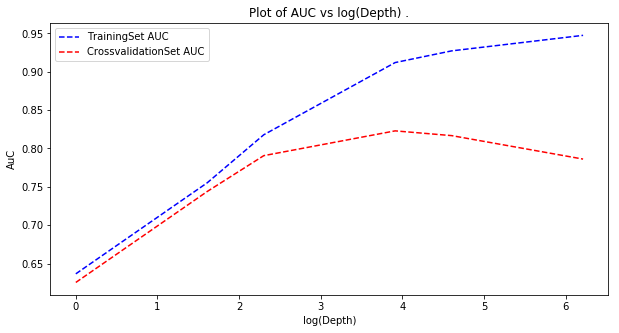

Starttime is : 2019-02-01 21:03:30.352515
Endtime   is : 2019-02-01 21:05:27.967035


In [41]:
import matplotlib.pyplot as plt
# plot inline
%matplotlib inline  

# Import the DecisionTreeClassifier .
from sklearn import tree
# Import the metrics module.
from sklearn.metrics import roc_auc_score

# Set the start time of the current cell run.
starttime_dt_bow = datetime.datetime.now()

# Set the range for the hyper-parameters.
# Experiment with depth ranges in [1, 5, 10, 50, 100, 500, 100].
# Here depth (tree-depth) is the hyper-parameter of the DecisionTreeClassifier

hp_depth = [1, 5, 10, 50, 100, 500]

# Use the cross-validation dataset to determine the best hyper-parameter depth (tree-depth).
plot_X_train = []
plot_lgX_train = []
plot_Y_train = []
plot_Y_cv = []

# Loop through various values of depth.
for i in hp_depth:
    dt_optimal = tree.DecisionTreeClassifier(criterion='gini',          # metric to measure quality of the
                                                                        # split.
                                             splitter = 'best',         # strategy used to split at each
                                                                        # node.
                                             max_depth=(i),             # Hyper-parameter, "Depth" of the
                                                                        # current iteration.
                                             min_samples_split = (500), # Hyper-parameter, "minimum sample
                                                                        # split" of the 
                                                                        # current iteration.
                                             class_weight='balanced')   # uses the values of y to 
                                                                        # automatically adjust weights 
                                                                        # in the input data.

    dt_optimal.fit(X_train_stdzd, Y_train)                              # fit the model on the training 
                                                                        # set.
    Y_pred_train = dt_optimal.predict_proba(X_train_stdzd)[:, 1]        # predict class probabilities in 
                                                                        # training set.    
    Y_pred_cv = dt_optimal.predict_proba(X_cv_stdzd)[:, 1]              # predict class probabilities in
                                                                        # CV set.

    # Compute AuC metric.
    plot_X_train.append(i)                  # plot (depth,min_sample_split) on the x-axis.
    plot_lgX_train.append(np.log(i))        # plot log(depth,min_sample_split) on the x-axis.
    # TrainingSet
    plot_Y_train.append(roc_auc_score(Y_train,Y_pred_train)) # plot trainingset auc score on the y-axis.
    # CV set
    plot_Y_cv.append(roc_auc_score(Y_cv,Y_pred_cv))     # plot cvset auc score on the y-axis.



# print X,Y
print("Depth :\n{}".format(plot_X_train))
print("\nLog of Depth :\n{}".format(plot_lgX_train))
print("\nTrainingSet AuC :\n{}".format(plot_Y_train))
print("\nCVset AuC :\n{}".format(plot_Y_cv))

print("\nPlot of AuC vs Log of Depth:")
# Plot X-axis = log(Depth),Y-axis = TrainingSet and CVSet AuC to determine the best hyper-parameter combo.
plt.figure(figsize=(10,5))                                           # set the figure size.
plt.plot(plot_lgX_train,plot_Y_train, 'b--',label="TrainingSet AUC") # plotting depth,trainingAuC separately. 
plt.plot(plot_lgX_train,plot_Y_cv, 'r--',label="CrossvalidationSet AUC") # plotting depth,CrossValidationAuC
                                                                         # separately. 

plt.title("Plot of AUC vs log(Depth) .")  # Set the title of the plot.
plt.xlabel("log(Depth)")                  # Set the x label of the plot.
plt.ylabel("AuC")                         # Set the y label of the plot.

# Display the plot.
plt.legend()                              # set the legend
plt.show()                                # display the plot.

# Set the end time of the current cell run.
endtime_dt_bow = datetime.datetime.now()

# Print the cell run duration.
print("Starttime is : {}".format(starttime_dt_bow))
print("Endtime   is : {}".format(endtime_dt_bow))


#### NOTE :
    . If the training score and the validation score are both low, the classifier is underfitting. 
    . If the training score is high and the validation score is low, the classifier is overfitting.
    . Otherwise it is working very well. 


#### OBSERVATION :  When the tree depth = 10, then training and cross-validation AUC is high, beyond which the training AuC continues to increase while the cross-validation AuC decreases. At tree depth = 10, the model neither Overfits nor Underfits.
#### The optimal hyper-parameter, Depth choosen is shown below :
    . Depth of tree = 10
    . Training AUC Score = 0.8178
    . CrossValidation AUC Score = 0.7906


#### [5.1.1.5] Hyper-Parameter Tuning : Using the cross-validation dataset to calculate the optimal 'min_sample_split' in BoW case.

Min_SampleSplit :
[5, 10, 100, 500]

Log of Min_SampleSplit :
[1.6094379124341003, 2.302585092994046, 4.605170185988092, 6.214608098422191]

TrainingSet AuC :
[0.830355376195361, 0.8297413288206927, 0.8245990421290065, 0.817855990573645]

CVset AuC :
[0.783787138855044, 0.7858480458511992, 0.7886911095384407, 0.790651436796673]

Plot of AuC vs Log of Min_SampleSplit:


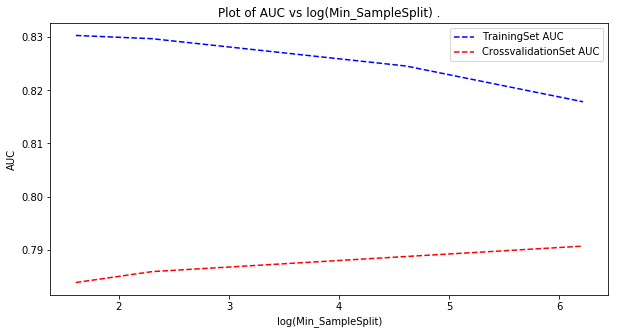

Starttime is : 2019-02-01 21:09:59.765640
Endtime   is : 2019-02-01 21:10:26.446003


In [42]:
import matplotlib.pyplot as plt
# plot inline
%matplotlib inline  

# Import the DecisionTreeClassifier .
from sklearn import tree
# Import the metrics module.
from sklearn.metrics import roc_auc_score

# Set the start time of the current cell run.
starttime_dt_bow = datetime.datetime.now()

# Set the range for the hyper-parameters.
# Experiment with min_sample_split ranges in [5, 10,100,500].
# Here depth (tree-depth) is the hyper-parameter of the DecisionTreeClassifier

hp_min_samples_split = [5, 10, 100, 500]

# Use the cross-validation dataset to determine the best hyper-parameter min_sample_split.
plot_X_train = []
plot_lgX_train = []
plot_Y_train = []
plot_Y_cv = []

# Loop through various values of depth.
for i in hp_min_samples_split:
    dt_optimal = tree.DecisionTreeClassifier(criterion='gini',          # metric to measure quality of the
                                                                        # split.
                                             splitter = 'best',         # strategy used to split at each
                                                                        # node.
                                             max_depth=(10),            # Hyper-parameter, "Depth" of the
                                                                        # current iteration.
                                             min_samples_split = (i),   # Hyper-parameter, "minimum sample
                                                                        # split" of the 
                                                                        # current iteration.
                                             class_weight='balanced')   # uses the values of y to 
                                                                        # automatically adjust weights 
                                                                        # in the input data.

    dt_optimal.fit(X_train_stdzd, Y_train)                              # fit the model on the training set.
    Y_pred_train = dt_optimal.predict_proba(X_train_stdzd)[:, 1]        # predict class probabilities in 
                                                                        # training set.    
    Y_pred_cv = dt_optimal.predict_proba(X_cv_stdzd)[:, 1]              # predict class probabilities in
                                                                        # CV set.

    # Compute AuC metric.
    plot_X_train.append(i)           # plot (min_sample_split) on the x-axis.
    plot_lgX_train.append(np.log(i)) # plot log(min_sample_split) on the x-axis.
    # TrainingSet
    plot_Y_train.append(roc_auc_score(Y_train,Y_pred_train)) # plot trainingset auc score on the y-axis.
    # CV set
    plot_Y_cv.append(roc_auc_score(Y_cv,Y_pred_cv))         # plot cvset auc score on the y-axis.



# print X,Y
print("Min_SampleSplit :\n{}".format(plot_X_train))
print("\nLog of Min_SampleSplit :\n{}".format(plot_lgX_train))
print("\nTrainingSet AuC :\n{}".format(plot_Y_train))
print("\nCVset AuC :\n{}".format(plot_Y_cv))

print("\nPlot of AuC vs Log of Min_SampleSplit:")
# Plot X-axis = log(Min_SampleSplit),Y-axis = TrainingSet and CVSet AuC to 
# determine the best hyper-parameter.
plt.figure(figsize=(10,5))                                                 # set the figure size.
plt.plot(plot_lgX_train,plot_Y_train, 'b--',label="TrainingSet AUC")       # plotting Min_SampleSplit,
                                                                           # trainingAuC separately. 
plt.plot(plot_lgX_train,plot_Y_cv, 'r--',label="CrossvalidationSet AUC")   # plotting Min_SampleSplit,CrossValidationAuC
                                                                           # separately. 

plt.title("Plot of AUC vs log(Min_SampleSplit) .")  # Set the title of the plot.
plt.xlabel("log(Min_SampleSplit)")                  # Set the x label of the plot.
plt.ylabel("AUC")                                   # Set the y label of the plot.

# Display the plot.
plt.legend()                              # set the legend
plt.show()                                # display the plot.

# Set the end time of the current cell run.
endtime_dt_bow = datetime.datetime.now()

# Print the cell run duration.
print("Starttime is : {}".format(starttime_dt_bow))
print("Endtime   is : {}".format(endtime_dt_bow))


#### NOTE :
    . If the training score and the validation score are both low, the classifier is underfitting. 
    . If the training score is high and the validation score is low, the classifier is overfitting.
    . Otherwise it is working very well. 

#### OBSERVATION :  When the min_sample_split = 500, then training AUC is low and cross-validation AUC is high. At this point the model neither Overfits nor Underfits.
#### The optimal hyper-parameter Min_Sample_Split choosen is shown below :
    . Min_Sample_Split   = 500
    . Training AUC Score = 0.8978
    . CV AUC Score       = 0.7906


#### [5.1.1.5] : Train and Fit the DecisionTree classifier in the training set. Compute the performance metrics by predicting the model on the test set.

In [43]:
# Import the DecisionTreeClassifier .
from sklearn import tree

# Set the start time of the current cell run.
starttime_dt_bow = datetime.datetime.now()

# The best value of the hyper-parameter depth-tree.
optimal_depthtree = 10

# The best value of the hyper-parameter minimum_samplesplit.
optimal_minsamplesplit = 500

# Instantiate the DecisionTree model with optimal hyper-paramters.
dt_optimal = tree.DecisionTreeClassifier(criterion='gini',  # metric to measure quality of the split.
                                         splitter = 'best', # strategy used to split at each node.
                                         max_depth=(optimal_depthtree), # Hyper-parameter, "Depth" 
                                                                        # of the current iteration.
                                         min_samples_split = (optimal_minsamplesplit), # Hyper-parameter,
                                                                                       #"minimum sample
                                                                                       # split" of the
                                                                                       # current iteration.
                                         class_weight='balanced') # uses the values of y to automatically 
                                                                  # adjust weights in the input data.

dt_optimal.fit(X_train_stdzd, Y_train)          # fit the model on the training set.
Y_pred_test = dt_optimal.predict(X_test_stdzd)  # predict,response from the DecisionTree model.
Y_pred_train_pb = dt_optimal.predict_proba(X_train_stdzd)[:, 1]  # predict class probabilities 
                                                                 # on the trainset.
Y_pred_cv_pb = dt_optimal.predict_proba(X_cv_stdzd)[:, 1]        # predict class probabilities
                                                                 # on the cvset.
Y_pred_test_pb = dt_optimal.predict_proba(X_test_stdzd)[:, 1]    # predict class probabilities
                                                                 # on the testset.

# Set the end time of the current cell run.
endtime_dt_bow = datetime.datetime.now()

# Print the cell run duration.
print("Starttime is : {}".format(starttime_dt_bow))
print("Endtime   is : {}".format(endtime_dt_bow))

Starttime is : 2019-02-01 21:27:50.558985
Endtime   is : 2019-02-01 21:27:56.101690


#### [5.1.1.6] : Plot the ROC Curve.

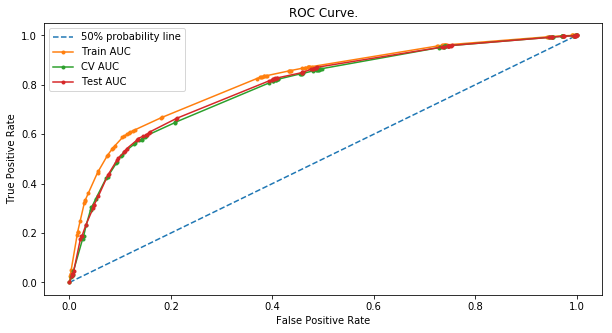

In [44]:
# Import the modules
from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt

# Calculate the RoC curve
fprTest, tprTest, thresholdsTest = roc_curve(Y_test,Y_pred_test_pb,pos_label=1) # compute the test roc curve.
fprCV, tprCV, thresholdsCV = roc_curve(Y_cv,Y_pred_cv_pb,pos_label=1)           # compute the cv roc curve.
fprTrain, tprTrain, thresholdsTrain = roc_curve(Y_train,Y_pred_train_pb,pos_label=1) # compute the train roc curve.

plt.figure(figsize=(10,5))  # set the figure size.
plt.plot([0, 1], [0, 1], linestyle='--',label="50% probability line") # plot the 50% probability line.
plt.plot(fprTrain, tprTrain, marker='.',label="Train AUC")  # plot the train roc curve for the model.
plt.plot(fprCV, tprCV, marker='.',label="CV AUC")           # plot the cv roc curve for the model.
plt.plot(fprTest, tprTest, marker='.',label="Test AUC")     # plot the test roc curve for the model.
plt.title("ROC Curve.")                                     # set the title of the plot.
plt.xlabel("False Positive Rate")                           # set the x label of the plot.
plt.ylabel("True Positive Rate")                            # set the y label of the plot.
plt.legend()                                                # set the legend
plt.show()                                                  # show the plot.

#### [5.1.1.7] Plot the classifier performance metrics.

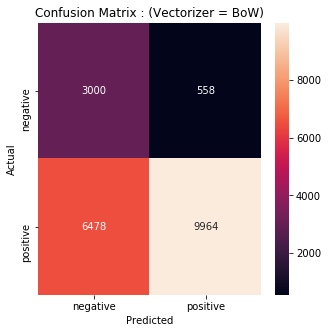


The class composition in the testset is :
1    16442
0     3558
Name: Comment, dtype: int64


In [45]:
# evaluate the model and report the metrics.
from sklearn.metrics import confusion_matrix
conf_mat = confusion_matrix(Y_test, Y_pred_test)
fig, ax = plt.subplots(figsize=(5,5))
sns.heatmap(conf_mat, annot=True, fmt='d'
            ,xticklabels=['negative','positive'], yticklabels=['negative','positive'])
plt.title('Confusion Matrix : (Vectorizer = BoW)')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

#Class composition in the testset.
dfYTest = pd.DataFrame(list(Y_test),columns=['Comment'])
print("\nThe class composition in the testset is :")
print(dfYTest["Comment"].value_counts())

### [5.1.2] Top 20 important features from<font color='red'> SET 1</font>

In [46]:
#featImp = dt_optimal.feature_importances_

# get the featureImportance FI for the dataset X_test_stdzd.
featImp = dt_optimal.feature_importances_

# get the indices of the features sorted by importance.
indices = np.argsort(featImp) #[::-1]

# get the feature names from the indices obtained above.
wordVector = np.take(count_vect.get_feature_names(), indices)

#print the feature importance score of the sorted features.
featImpScore = featImp[indices]

# Prepare the data from the columnIndex,weightvector and wordvector.
lstData = list(zip(indices,featImpScore,wordVector))

# create a dataframe to store the columnindex,weights,words of the text corpus.
dfTopWords = pd.DataFrame(data=lstData,columns=['ColumnIndex','FeatureImportanceSore','Word'])

# Get the top 20 features with their featureImportance score.
dfTopWords[['ColumnIndex','Word','FeatureImportanceSore'
          ]].sort_values(['FeatureImportanceSore'],ascending=False).head(20)


,ColumnIndex,Word,FeatureImportanceSore
4999,2843,not,0.286897
4998,1846,great,0.153915
4997,2482,love,0.067722
4996,1050,delicious,0.067455
4995,319,best,0.060369
4994,1121,disappointed,0.055273
4993,1769,good,0.044836
4992,3225,perfect,0.037914
4991,2503,loves,0.037146
4990,1351,excellent,0.021557


### [5.1.3] Graphviz visualization of Decision Tree on BOW,<font color='red'> SET 1</font>

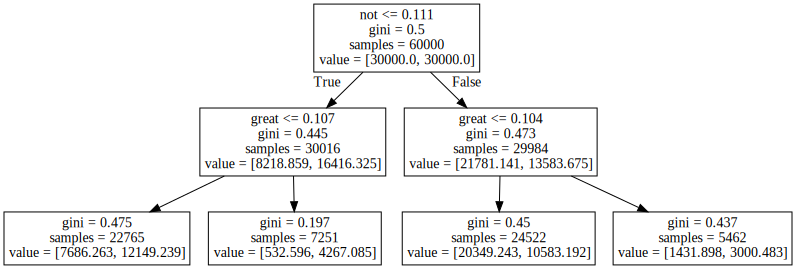

In [47]:
# Set the system path.
#import os
#os.environ["PATH"] += os.pathsep + 'C:\\Program Files (x86)\\Graphviz2.38\\bin\\'

# Import the DecisionTreeClassifier .
from sklearn import tree
import graphviz

# Set the start time of the current cell run.
starttime_dt_bow = datetime.datetime.now()

# The best value of the hyper-parameter depth-tree.
optimal_depthtree_gvz = 2

# The best value of the hyper-parameter minimum_samplesplit.
optimal_minsamplesplit = 500

# Instantiate the DecisionTree model with optimal hyper-paramters.
dt_optimal = tree.DecisionTreeClassifier(criterion='gini',  # metric to measure quality of the split.
                                         splitter = 'best', # strategy used to split at each node.
                                         max_depth=(optimal_depthtree_gvz), # Hyper-parameter, 
                                                                            # "Depth" of the current iteration.
                                         min_samples_split = (optimal_minsamplesplit), # Hyper-parameter,
                                                                                       # "minimum sample split" 
                                                                                       # of the current iteration.
                                         class_weight='balanced') # uses the values of y to automatically 
                                                                  # adjust weights in the input data.

dt_optimal.fit(X_train_stdzd, Y_train)                 # fit the model on the training set.


terms = count_vect.get_feature_names()
dot_data = tree.export_graphviz(dt_optimal, out_file = None, feature_names = terms)
graph = graphviz.Source(dot_data)
graph

### [5.1.4] : Load metrics into the summary table for BoW.

In [48]:
# Import the metrics module.
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score

# Add the classification metrics to the table.
# Add the classification metrics to the final summary table.
summaryTable.add_row(['BoW',optimal_depthtree,optimal_minsamplesplit,'Accuracy',accuracy_score(Y_test,Y_pred_test)])
summaryTable.add_row(['',optimal_depthtree,optimal_minsamplesplit,'Precision',precision_score(Y_test,Y_pred_test)])
summaryTable.add_row(['',optimal_depthtree,optimal_minsamplesplit,'Recall',recall_score(Y_test,Y_pred_test)])
summaryTable.add_row(['',optimal_depthtree,optimal_minsamplesplit,'F1 Score',f1_score(Y_test,Y_pred_test)])
summaryTable.add_row(['',optimal_depthtree,optimal_minsamplesplit,'AUC Score',roc_auc_score(Y_test,Y_pred_test_pb)])
summaryTable.add_row(['',optimal_depthtree,optimal_minsamplesplit,'ConfusionMatrix',confusion_matrix(Y_test, Y_pred_test)])
summaryTable.add_row(['----------','----------','-----------','----------','----------'])


## [5.2] Applying Decision Trees on TFIDF,<font color='red'> SET 2</font>

#### [5.2.1.1] Convert review text into numeric vectors using TF_IDF

In [50]:
#TF-IDF
# Apply TF-IDF vectorization only on the trainingset.
tf_idf_vect = TfidfVectorizer(dtype='float64',ngram_range=(1,2),min_df=10, max_features=5000)

#Train you tf-idf vectorizer on the train data (.fit_transform()) and 
#use the same vectorizer on the test set as well (.transform())
final_tf_idf = tf_idf_vect.fit_transform(X_train.values.astype('U'))

print("the type of TIDF vectorizer ",type(final_tf_idf))
print("the shape of out text TFIDF vectorizer ",final_tf_idf.get_shape())
print("the number of unique words including both unigrams and bigrams ", final_tf_idf.get_shape()[1])

the type of TIDF vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text TFIDF vectorizer  (60000, 5000)
the number of unique words including both unigrams and bigrams  5000


#### [5.2.1.2] Use the TF-IDF vectorizer trained in the preceding step to convert cvset and testset to vectors.

In [51]:
#use the same countvectorizer on the cvset and testset.
final_tf_idf_cvset = tf_idf_vect.transform(X_cv.values)
print("the type of TFIDF vectorizer ",type(final_tf_idf_cvset))
print("the shape of out text TFIDF vectorizer ",final_tf_idf_cvset.get_shape())
print("the number of unique words ", final_tf_idf_cvset.get_shape()[1])

#use the same countvectorizer on the testset.
final_tf_idf_testset = tf_idf_vect.transform(X_test.values)
print("the type of TFIDF vectorizer ",type(final_tf_idf_testset))
print("the shape of out text TFIDF vectorizer ",final_tf_idf_testset.get_shape())
print("the number of unique words ", final_tf_idf_testset.get_shape()[1])

the type of TFIDF vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text TFIDF vectorizer  (20000, 5000)
the number of unique words  5000
the type of TFIDF vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text TFIDF vectorizer  (20000, 5000)
the number of unique words  5000


#### [5.2.1.3] Standardize / Normalize the data

In [52]:
# Data-preprocessing: Normalizing the data
from sklearn.preprocessing import Normalizer

# Initialize the Normalizer.
normalizer = Normalizer()

#Standardize on the train data. 
X_train_stdzd = normalizer.fit_transform(final_tf_idf)

#Standardize on the cv and test data.
X_cv_stdzd    = normalizer.transform(final_tf_idf_cvset)     #use the same Normalizer on the cvset.
X_test_stdzd  = normalizer.transform(final_tf_idf_testset)   #use the same Normalizer on the testset.

#### [5.2.1.4] Hyper-Parameter Tuning : Using the cross-validation dataset to calculate the optimal 'depth of tree' in TFIDF case.

Depth :
[1, 5, 10, 50, 100, 500]

Log of Depth :
[0.0, 1.6094379124341003, 2.302585092994046, 3.912023005428146, 4.605170185988092, 6.214608098422191]

TrainingSet AuC :
[0.6347216783207609, 0.751462794281927, 0.8173589532708914, 0.9141275556223386, 0.9307184019177068, 0.9518610299124406]

CVset AuC :
[0.6220847918629933, 0.7362521831109041, 0.7831088780960312, 0.8104443440034794, 0.8060160189232202, 0.7696426060903483]

Plot of AuC vs Log of Depth:


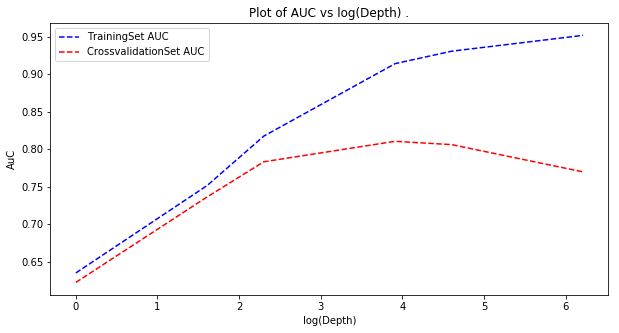

Starttime is : 2019-02-01 21:41:41.347015
Endtime   is : 2019-02-01 21:43:55.531591


In [53]:
import matplotlib.pyplot as plt
# plot inline
%matplotlib inline  

# Import the DecisionTreeClassifier .
from sklearn import tree
# Import the metrics module.
from sklearn.metrics import roc_auc_score

# Set the start time of the current cell run.
starttime_dt_tfidf = datetime.datetime.now()

# Set the range for the hyper-parameters.
# Experiment with depth ranges in [1, 5, 10, 50, 100, 500, 100].
# Here depth (tree-depth) is the hyper-parameter of the DecisionTreeClassifier

hp_depth = [1, 5, 10, 50, 100, 500]

# Use the cross-validation dataset to determine the best hyper-parameter depth (tree-depth).
plot_X_train = []
plot_lgX_train = []
plot_Y_train = []
plot_Y_cv = []

# Loop through various values of depth.
for i in hp_depth:
    dt_optimal = tree.DecisionTreeClassifier(# metric to measure quality of the split.
                                             criterion='gini',
                                             # strategy used to split at each node.
                                             splitter = 'best',
                                             # Hyper-parameter, "Depth" of the current iteration.
                                             max_depth=(i),
                                             # Hyper-parameter, "minimum sample split" of the 
                                             # current iteration.
                                             min_samples_split = (500), 
                                             # uses the values of y to automatically 
                                             # adjust weights in the input data.
                                             class_weight='balanced')   
                                                                        

    # fit the model on the training set.
    dt_optimal.fit(X_train_stdzd, Y_train) 
    # predict class probabilities in training set.    
    Y_pred_train = dt_optimal.predict_proba(X_train_stdzd)[:, 1]  
    # predict class probabilities in CV set.
    Y_pred_cv = dt_optimal.predict_proba(X_cv_stdzd)[:, 1]              

    # Compute AuC metric.
    plot_X_train.append(i)           # plot (depth,min_sample_split) on the x-axis.
    plot_lgX_train.append(np.log(i)) # plot log(depth,min_sample_split) on the x-axis.
    # TrainingSet
    plot_Y_train.append(roc_auc_score(Y_train,Y_pred_train)) # plot trainingset auc score on the y-axis.
    # CV set
    plot_Y_cv.append(roc_auc_score(Y_cv,Y_pred_cv)) # plot cvset auc score on the y-axis.



# print X,Y
print("Depth :\n{}".format(plot_X_train))
print("\nLog of Depth :\n{}".format(plot_lgX_train))
print("\nTrainingSet AuC :\n{}".format(plot_Y_train))
print("\nCVset AuC :\n{}".format(plot_Y_cv))

print("\nPlot of AuC vs Log of Depth:")
# Plot X-axis = log(Depth),Y-axis = TrainingSet and CVSet AuC to determine the best hyper-parameter combo.

# set the figure size.
plt.figure(figsize=(10,5))   
# plotting depth,trainingAuC separately. 
plt.plot(plot_lgX_train,plot_Y_train, 'b--',label="TrainingSet AUC")    
# plotting depth,CrossValidationAuC separately. 
plt.plot(plot_lgX_train,plot_Y_cv, 'r--',label="CrossvalidationSet AUC")   

plt.title("Plot of AUC vs log(Depth) .")  # Set the title of the plot.
plt.xlabel("log(Depth)")                  # Set the x label of the plot.
plt.ylabel("AuC")                         # Set the y label of the plot.

# Display the plot.
plt.legend()                              # set the legend
plt.show()                                # display the plot.

# Set the end time of the current cell run.
endtime_dt_tfidf = datetime.datetime.now()

# Print the cell run duration.
print("Starttime is : {}".format(starttime_dt_tfidf))
print("Endtime   is : {}".format(endtime_dt_tfidf))


#### NOTE :
    . If the training score and the validation score are both low, the classifier is underfitting. 
    . If the training score is high and the validation score is low, the classifier is overfitting.
    . Otherwise it is working very well. 


#### OBSERVATION :  When the tree depth = 10, then training and cross-validation AUC is high, beyond which the training AuC continues to increase while the cross-validation AuC decreases. At tree depth = 10, the model neither Overfits nor Underfits.
#### The optimal hyper-parameter, Depth choosen is shown below :
    . Depth of tree = 10
    . Training AUC Score = 0.8173
    . CrossValidation AUC Score = 0.7831


#### [5.2.1.5] Hyper-Parameter Tuning : Using the cross-validation dataset to calculate the optimal 'min_sample_split' in TFIDF case.

Min_SampleSplit :
[5, 10, 100, 500]

Log of Min_SampleSplit :
[1.6094379124341003, 2.302585092994046, 4.605170185988092, 6.214608098422191]

TrainingSet AuC :
[0.8302429227135781, 0.8297182598629835, 0.8230247822121718, 0.8173589532708914]

CVset AuC :
[0.7770529390860269, 0.775347571170307, 0.7805363383300827, 0.7831088780960312]

Plot of AuC vs Log of Min_SampleSplit:


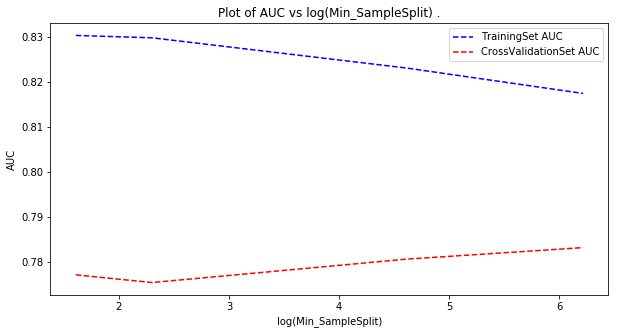

Starttime is : 2019-02-01 21:45:23.942756
Endtime   is : 2019-02-01 21:45:53.690309


In [54]:
import matplotlib.pyplot as plt
# plot inline
%matplotlib inline  

# Import the DecisionTreeClassifier .
from sklearn import tree
# Import the metrics module.
from sklearn.metrics import roc_auc_score

# Set the start time of the current cell run.
starttime_dt_tfidf = datetime.datetime.now()

# Set the range for the hyper-parameters.
# Experiment with min_sample_split ranges in [5, 10,100,500].
# Here min_samples_split is the other hyper-parameter of the DecisionTreeClassifier

hp_min_samples_split = [5, 10, 100, 500]

# Use the cross-validation dataset to determine the best hyper-parameter min_sample_split.
plot_X_train = []
plot_lgX_train = []
plot_Y_train = []
plot_Y_cv = []

# Loop through various values of min_samples_split.
for i in hp_min_samples_split:
    dt_optimal = tree.DecisionTreeClassifier(# metric to measure quality of the split.
                                             criterion='gini',
                                             # strategy used to split at each node.
                                             splitter = 'best', 
                                             # Hyper-parameter, "Depth" of the current iteration.
                                             max_depth=(10), 
                                             # Hyper-parameter, "minimum sample split" of the 
                                             # current iteration.
                                             min_samples_split = (i),
                                             # uses the values of y to automatically 
                                             # adjust weights in the input data.
                                             class_weight='balanced')   

    # fit the model on the training set.
    dt_optimal.fit(X_train_stdzd, Y_train) 
    # predict class probabilities in training set.    
    Y_pred_train = dt_optimal.predict_proba(X_train_stdzd)[:, 1]
    # predict class probabilities in CV set.
    Y_pred_cv = dt_optimal.predict_proba(X_cv_stdzd)[:, 1]              

    # Compute AuC metric.
    plot_X_train.append(i)           # plot (min_sample_split) on the x-axis.
    plot_lgX_train.append(np.log(i)) # plot log(min_sample_split) on the x-axis.
    # TrainingSet
    plot_Y_train.append(roc_auc_score(Y_train,Y_pred_train)) # plot trainingset auc score on the y-axis.
    # CV set
    plot_Y_cv.append(roc_auc_score(Y_cv,Y_pred_cv)) # plot cvset auc score on the y-axis.



# print X,Y
print("Min_SampleSplit :\n{}".format(plot_X_train))
print("\nLog of Min_SampleSplit :\n{}".format(plot_lgX_train))
print("\nTrainingSet AuC :\n{}".format(plot_Y_train))
print("\nCVset AuC :\n{}".format(plot_Y_cv))

print("\nPlot of AuC vs Log of Min_SampleSplit:")
# Plot X-axis = log(Min_SampleSplit),Y-axis = TrainingSet and CVSet AuC to determine the best hyper-parameter.

# set the figure size.
plt.figure(figsize=(10,5))   
# plotting Min_SampleSplit,trainingAuC separately. 
plt.plot(plot_lgX_train,plot_Y_train, 'b--',label="TrainingSet AUC")  
# plotting Min_SampleSplit,CrossValidationAuC separately. 
plt.plot(plot_lgX_train,plot_Y_cv, 'r--',label="CrossValidationSet AUC")   

plt.title("Plot of AUC vs log(Min_SampleSplit) .")  # Set the title of the plot.
plt.xlabel("log(Min_SampleSplit)")                  # Set the x label of the plot.
plt.ylabel("AUC")                                   # Set the y label of the plot.

# Display the plot.
plt.legend()                              # set the legend
plt.show()                                # display the plot.

# Set the end time of the current cell run.
endtime_dt_tfidf = datetime.datetime.now()

# Print the cell run duration.
print("Starttime is : {}".format(starttime_dt_tfidf))
print("Endtime   is : {}".format(endtime_dt_tfidf))


#### NOTE :
    . If the training score and the validation score are both low, the classifier is underfitting. 
    . If the training score is high and the validation score is low, the classifier is overfitting.
    . Otherwise it is working very well. 

#### OBSERVATION :  When the min_sample_split = 500, then training AUC is low and cross-validation AUC is high. At this point the model neither Overfits nor Underfits.
#### The optimal hyper-parameter Min_Sample_Split choosen is shown below :
    . Min_Sample_Split = 500
    . Training AUC Score = 0.8173
    . CV AUC Score = 0.7831


#### [5.2.1.5] : Train and Fit the DecisionTree classifier in the training set. Compute the performance metrics by predicting the model on the test set.

In [55]:
# Import the DecisionTreeClassifier.
from sklearn import tree

# Set the start time of the current cell run.
starttime_dt_tfidf = datetime.datetime.now()

# The best value of the hyper-parameter depth-tree.
optimal_depthtree = 10

# The best value of the hyper-parameter minimum_samplesplit.
optimal_minsamplesplit = 500

# Instantiate the DecisionTree model with optimal hyper-paramters.
dt_optimal = tree.DecisionTreeClassifier(# metric to measure quality of the split.
                                         criterion='gini',
                                         # strategy used to split at each node.
                                         splitter = 'best',  
                                         # Hyper-parameter, "Depth" of the current iteration.
                                         max_depth=(optimal_depthtree),
                                         # Hyper-parameter, "minimum sample split" 
                                         # of the current iteration.
                                         min_samples_split = (optimal_minsamplesplit), 
                                         # uses the values of y to automatically 
                                         # adjust weights in the input data.                                              
                                         class_weight='balanced') 

# fit the model on the training set.
dt_optimal.fit(X_train_stdzd, Y_train)  
# predict,response from the DecisionTree model.
Y_pred_test = dt_optimal.predict(X_test_stdzd)
# predict class probabilities on the trainset.
Y_pred_train_pb = dt_optimal.predict_proba(X_train_stdzd)[:, 1] 
# predict class probabilities on the cvset.
Y_pred_cv_pb = dt_optimal.predict_proba(X_cv_stdzd)[:, 1] 
# predict class probabilities on the testset.
Y_pred_test_pb = dt_optimal.predict_proba(X_test_stdzd)[:, 1]    

# Set the end time of the current cell run.
endtime_dt_tfidf = datetime.datetime.now()

# Print the cell run duration.
print("Starttime is : {}".format(starttime_dt_tfidf))
print("Endtime   is : {}".format(endtime_dt_tfidf))

Starttime is : 2019-02-01 21:46:55.110596
Endtime   is : 2019-02-01 21:47:01.463463


#### [5.2.1.6] : Plot the ROC Curve.

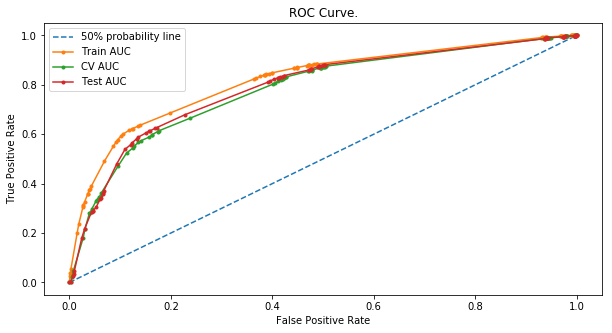

In [56]:
# Import the modules
from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt

# Calculate the RoC curve
# compute the test roc curve.
fprTest, tprTest, thresholdsTest = roc_curve(Y_test,Y_pred_test_pb,pos_label=1)
# compute the cv roc curve.
fprCV, tprCV, thresholdsCV = roc_curve(Y_cv,Y_pred_cv_pb,pos_label=1)  
# compute the train roc curve.
fprTrain, tprTrain, thresholdsTrain = roc_curve(Y_train,Y_pred_train_pb,pos_label=1) 

plt.figure(figsize=(10,5))  # set the figure size.
plt.plot([0, 1], [0, 1], linestyle='--',label="50% probability line") # plot the 50% probability line.
plt.plot(fprTrain, tprTrain, marker='.',label="Train AUC")  # plot the train roc curve for the model.
plt.plot(fprCV, tprCV, marker='.',label="CV AUC")           # plot the cv roc curve for the model.
plt.plot(fprTest, tprTest, marker='.',label="Test AUC")     # plot the test roc curve for the model.
plt.title("ROC Curve.")                                     # set the title of the plot.
plt.xlabel("False Positive Rate")                           # set the x label of the plot.
plt.ylabel("True Positive Rate")                            # set the y label of the plot.
plt.legend()                                                # set the legend
plt.show()                                                  # show the plot.

#### [5.2.1.7] Plot the classifier performance metrics.

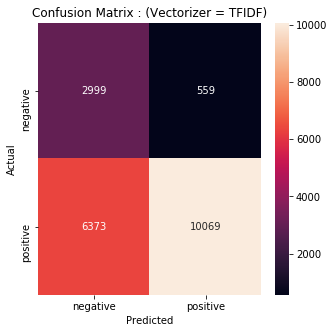


The class composition in the testset is :
1    16442
0     3558
Name: Comment, dtype: int64


In [57]:
# evaluate the model and report the metrics.
from sklearn.metrics import confusion_matrix
conf_mat = confusion_matrix(Y_test, Y_pred_test)
fig, ax = plt.subplots(figsize=(5,5))
sns.heatmap(conf_mat, annot=True, fmt='d'
            ,xticklabels=['negative','positive'], yticklabels=['negative','positive'])
plt.title('Confusion Matrix : (Vectorizer = TFIDF)')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

#Class composition in the testset.
dfYTest = pd.DataFrame(list(Y_test),columns=['Comment'])
print("\nThe class composition in the testset is :")
print(dfYTest["Comment"].value_counts())

### [5.2.2] Top 20 important features from<font color='red'> SET 2</font>

In [58]:
#featImp = dt_optimal.feature_importances_

# get the featureImportance FI for the dataset X_test_stdzd.
featImp = dt_optimal.feature_importances_

# get the indices of the features sorted by importance.
indices = np.argsort(featImp) #[::-1]

# get the feature names from the indices obtained above.
wordVector = np.take(tf_idf_vect.get_feature_names(), indices)

#print the feature importance score of the sorted features.
featImpScore = featImp[indices]

# Prepare the data from the columnIndex,weightvector and wordvector.
lstData = list(zip(indices,featImpScore,wordVector))

# create a dataframe to store the columnindex,weights,words of the text corpus.
dfTopWords = pd.DataFrame(data=lstData,columns=['ColumnIndex','FeatureImportanceSore','Word'])

# Get the top 20 features with their featureImportance score.
dfTopWords[['ColumnIndex','Word','FeatureImportanceSore'
          ]].sort_values(['FeatureImportanceSore'],ascending=False).head(20)

,ColumnIndex,Word,FeatureImportanceSore
4999,2843,not,0.268601
4998,1846,great,0.152321
4997,2482,love,0.073445
4996,1050,delicious,0.067353
4995,319,best,0.061932
4994,1121,disappointed,0.047470
4993,1769,good,0.042738
4992,3225,perfect,0.039068
4991,2503,loves,0.035953
4990,2805,nice,0.016338


### [5.2.3] Graphviz visualization of Decision Tree on TFIDF,<font color='red'> SET 2</font>

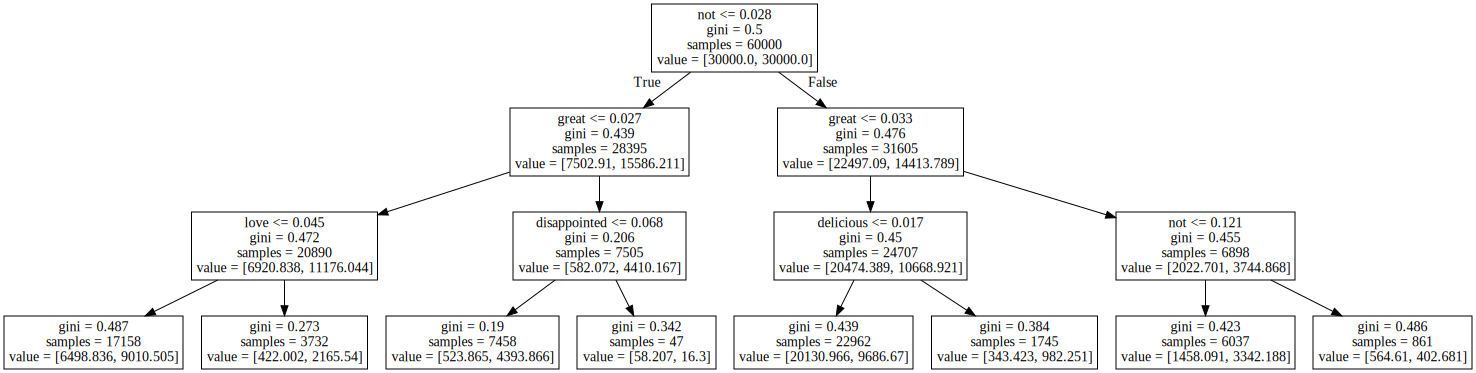

In [59]:
# Import the DecisionTreeClassifier .
from sklearn import tree
import graphviz

# Set the start time of the current cell run.
starttime_dt_bow = datetime.datetime.now()

# The best value of the hyper-parameter depth-tree.
optimal_depthtree_gvz = 3

# The best value of the hyper-parameter minimum_samplesplit.
optimal_minsamplesplit = 500

# Instantiate the DecisionTree model with optimal hyper-paramters.
dt_optimal = tree.DecisionTreeClassifier(criterion='gini', # metric to measure quality of the split.
                                         splitter = 'best',# strategy used to split at each node.
                                         max_depth=(optimal_depthtree_gvz), # Hyper-parameter, "Depth"
                                                                            # of the current iteration.
                                         min_samples_split = (optimal_minsamplesplit), # Hyper-parameter,
                                                #"minimum sample split" of the current iteration.
                                         class_weight='balanced') # uses the values of y to automatically 
                                                                  # adjust weights in the input data.

dt_optimal.fit(X_train_stdzd, Y_train)  # fit the model on the training set.


terms = tf_idf_vect.get_feature_names()
dot_data = tree.export_graphviz(dt_optimal, out_file = None, feature_names = terms)
graph = graphviz.Source(dot_data)
graph

### [5.2.4] : Load metrics into the summary table for TF-IDF.

In [60]:
# Import the metrics module.
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score

# Add the classification metrics to the summary table.
summaryTable.add_row(['TF-IDF',optimal_depthtree,optimal_minsamplesplit,'Accuracy',accuracy_score(Y_test,Y_pred_test)])
summaryTable.add_row(['',optimal_depthtree,optimal_minsamplesplit,'Precision',precision_score(Y_test,Y_pred_test)])
summaryTable.add_row(['',optimal_depthtree,optimal_minsamplesplit,'Recall',recall_score(Y_test,Y_pred_test)])
summaryTable.add_row(['',optimal_depthtree,optimal_minsamplesplit,'F1 Score',f1_score(Y_test,Y_pred_test)])
summaryTable.add_row(['',optimal_depthtree,optimal_minsamplesplit,'AUC Score',roc_auc_score(Y_test,Y_pred_test_pb)])
summaryTable.add_row(['',optimal_depthtree,optimal_minsamplesplit,'ConfusionMatrix',confusion_matrix(Y_test, Y_pred_test)])
summaryTable.add_row(['----------','----------','-----------','----------','----------'])


## [5.3] Applying Decision Trees on AVG W2V,<font color='red'> SET 3</font>

#### [5.3.1] Convert review text into numeric vectors using Avg W2V

In [62]:
# Train your own Word2Vec model using your own text training corpus.
# Train Word2Vec on training set alone.
i=0
list_of_sent=[]  # List to store the sentence from the review comments.

# Loop through all the Amazon Food Review comments, one comment at a time.
for sent in tqdm(X_train.values.astype('U')):
    list_of_sent.append(sent.split())         # From the Review, split it into individual sentence and add to the list.

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 60000/60000 [00:02<00:00, 29161.02it/s]


#### [5.3.2] Train the Word2Vec model on the training set alone.

In [63]:
# Instantiate the Word2Vec vectorizer.

# Word2Vec(list,word_repeat_count,dimension_of_each_word_vector,Number_of_Processor_cores)
# min_count = 5 considers only words that occured atleast 5 times
w2v_model=Word2Vec(list_of_sent,min_count=5,size=50, workers=4)

# Store the word vocabulary.
w2v_words = list(w2v_model.wv.vocab)

# Print the Word vector.
print("number of words that occured minimum 5 times ",len(w2v_words))
print("sample words ", w2v_words[0:50])

number of words that occured minimum 5 times  15844
sample words  ['big', 'lover', 'fig', 'jam', 'unique', 'flavor', 'kind', 'mix', 'light', 'figs', 'dark', 'mission', 'must', 'great', 'product', 'good', 'price', 'definitely', 'ordering', 'used', 'bottles', 'ordered', 'expected', 'box', 'full', 'fortune', 'cookies', 'like', 'one', 'nonetheless', 'got', 'small', 'tasted', 'weird', 'okay', 'not', 'best', 'reviewing', 'review', 'amazon', 'checked', 'label', 'container', 'sure', 'enough', 'contains', 'propylene', 'glycol', 'top', 'ingredients']


#### [5.3.3] Compute the average Word2Vec for each review in the training set.

In [64]:
# average Word2Vec
# Avg. Word2Vec = (W2V(w1)+W2V(w2)+W2V(w3)+...... +W2V(w364171)) / 364171
# compute average word2vec for each review.
sent_vectors = [];                     # the avg-w2v for each sentence/review is stored in this list
for sent in tqdm(list_of_sent):        # for each review/sentence in the training set
    sent_vec = np.zeros(50)            # as word vectors are of zero length
    cnt_words =0;                      # num of words with a valid vector in the sentence/review
    for word in sent:                  # for each word in a review/sentence
        if word in w2v_words:          # if the word exists in the vocabulary
            vec = w2v_model.wv[word]   # convert the word to vector
            sent_vec += vec            # sum the vectors
            cnt_words += 1             # compute the word count
    if cnt_words != 0:
        sent_vec /= cnt_words          # compute the average word count
    sent_vectors.append(sent_vec)      # update the average word count to the list.
print('The total number of words is {}'.format(len(sent_vectors)))
print('The dimension of each word vector is {}'.format(len(sent_vectors[0])))

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 60000/60000 [03:31<00:00, 283.06it/s]


The total number of words is 60000
The dimension of each word vector is 50


#### [5.3.4] Build the text corpus of the cross-validation and test set.

In [65]:
# Build the cross-validation text corpus.
i=0
list_of_sent_cv=[]   # List to store the sentence from the review comments.

# Loop through all the Amazon Food Review comments, one comment at a time.
for sent in tqdm(X_cv.values):
    list_of_sent_cv.append(sent.split()) # From the Review, split it into individual sentence
                                         # and add to the list.
    
# Build the test text corpus.
i=0
list_of_sent_test=[]  # List to store the sentence from the review comments.

# Loop through all the Amazon Food Review comments, one comment at a time.
for sent in tqdm(X_test.values):
    list_of_sent_test.append(sent.split()) # From the Review, split it into individual sentence
                                           # and add to the list.

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20000/20000 [00:00<00:00, 133477.30it/s]


#### [5.3.5] Use the trained word2vec model to compute the average Word2Vec for each review in the cross-validation and test set.

In [66]:
# CROSS-VALIDATION :

# average Word2Vec
# Avg. Word2Vec = (W2V(w1)+W2V(w2)+W2V(w3)+...... +W2V(w364171)) / 364171
# compute average word2vec for each review.
sent_vectors_cv = [];                # the avg-w2v for each sentence/review is stored in this list
for sent in tqdm(list_of_sent_cv):   # for each review/sentence in the test set
    sent_vec = np.zeros(50)            # as word vectors are of zero length
    cnt_words =0;                      # num of words with a valid vector in the sentence/review
    for word in sent:                  # for each word in a review/sentence
        if word in w2v_words:          # if the word exists in the vocabulary
            vec = w2v_model.wv[word]   # convert the word to vector using the trained model.
            sent_vec += vec            # sum the vectors
            cnt_words += 1             # compute the word count
    if cnt_words != 0:
        sent_vec /= cnt_words          # compute the average word count
    sent_vectors_cv.append(sent_vec)   # update the average word count to the list. 

print('The total number of words is {}'.format(len(sent_vectors_cv)))
print('The dimension of each word vector is {}'.format(len(sent_vectors_cv[0])))

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20000/20000 [01:25<00:00, 234.16it/s]


The total number of words is 20000
The dimension of each word vector is 50


In [67]:
# TEST :

# average Word2Vec
# Avg. Word2Vec = (W2V(w1)+W2V(w2)+W2V(w3)+...... +W2V(w364171)) / 364171
# compute average word2vec for each review.
sent_vectors_test = [];                # the avg-w2v for each sentence/review is stored in this list
for sent in tqdm(list_of_sent_test):   # for each review/sentence in the test set
    sent_vec = np.zeros(50)            # as word vectors are of zero length
    cnt_words =0;                      # num of words with a valid vector in the sentence/review
    for word in sent:                  # for each word in a review/sentence
        if word in w2v_words:          # if the word exists in the vocabulary
            vec = w2v_model.wv[word]   # convert the word to vector using the trained model.
            sent_vec += vec            # sum the vectors
            cnt_words += 1             # compute the word count
    if cnt_words != 0:
        sent_vec /= cnt_words          # compute the average word count
    sent_vectors_test.append(sent_vec) # update the average word count to the list.

print('The total number of words is {}'.format(len(sent_vectors_test)))
print('The dimension of each word vector is {}'.format(len(sent_vectors_test[0])))

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20000/20000 [01:21<00:00, 246.26it/s]


The total number of words is 20000
The dimension of each word vector is 50


#### [5.3.6] Standardize / Normalize the data

In [68]:
# Data-preprocessing: Normalizing the data
from sklearn.preprocessing import Normalizer

normalizer = Normalizer()

#Standardize on the train data.
X_train_stdzd = normalizer.fit_transform(sent_vectors)

#Standardize the cv and test data.
X_cv_stdzd  = normalizer.transform(sent_vectors_cv)      #use the same Normalizer on the cv set.
X_test_stdzd  = normalizer.transform(sent_vectors_test)  #use the same Normalizer on the test set.

#### [5.3.7] Hyper-Parameter Tuning : Using the cross-validation dataset to calculate the optimal 'depth of tree' in AvgWord2Vec case.

Depth :
[1, 5, 10, 50, 100, 500]

Log of Depth :
[0.0, 1.6094379124341003, 2.302585092994046, 3.912023005428146, 4.605170185988092, 6.214608098422191]

TrainingSet AuC :
[0.6392074480312111, 0.8204923000889203, 0.8732625862390322, 0.880648025246461, 0.880648025246461, 0.880648025246461]

CVset AuC :
[0.6274012368043251, 0.8003773002048581, 0.8166375734513317, 0.8146008789792241, 0.8146008789792241, 0.8146008789792241]

Plot of AuC vs Log of Depth:


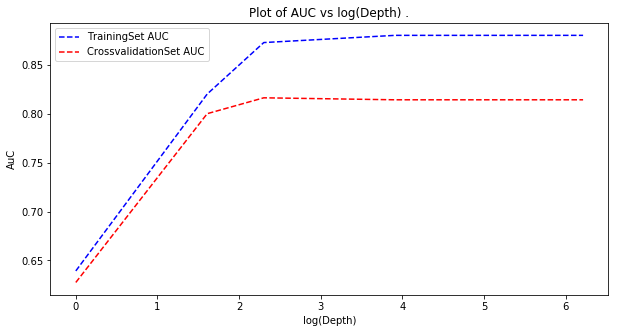

Starttime is : 2019-02-01 22:05:48.201587
Endtime   is : 2019-02-01 22:06:26.761377


In [69]:
import matplotlib.pyplot as plt
# plot inline
%matplotlib inline  

# Import the DecisionTreeClassifier .
from sklearn import tree
# Import the metrics module.
from sklearn.metrics import roc_auc_score

# Set the start time of the current cell run.
starttime_dt_avgw2v = datetime.datetime.now()

# Set the range for the hyper-parameters.
# Experiment with depth ranges in [1, 5, 10, 50, 100, 500, 100].
# Here depth (tree-depth) is the hyper-parameter of the DecisionTreeClassifier

hp_depth = [1, 5, 10, 50, 100, 500]

# Use the cross-validation dataset to determine the best hyper-parameter depth (tree-depth).
plot_X_train = []
plot_lgX_train = []
plot_Y_train = []
plot_Y_cv = []

# Loop through various values of depth.
for i in hp_depth:
    dt_optimal = _
    tree.DecisionTreeClassifier(criterion='gini',   # metric to measure quality of the split.
                                splitter = 'best',  # strategy used to split at each node.
                                max_depth=(i),      # Hyper-parameter, "Depth" of the current iteration.
                                min_samples_split = (500), # Hyper-parameter, 
                                                           #"minimum sample split" of the 
                                                           # current iteration.
                                class_weight='balanced')   # uses the values of y to automatically 
                                                           # adjust weights in the input data.

    dt_optimal.fit(X_train_stdzd, Y_train)  # fit the model on the training set.
    Y_pred_train = dt_optimal.predict_proba(X_train_stdzd)[:, 1] # predict class probabilities in training set.    
    Y_pred_cv = dt_optimal.predict_proba(X_cv_stdzd)[:, 1]      # predict class probabilities in CV set.

    # Compute AuC metric.
    plot_X_train.append(i)           # plot (depth,min_sample_split) on the x-axis.
    plot_lgX_train.append(np.log(i)) # plot log(depth,min_sample_split) on the x-axis.
    # TrainingSet
    plot_Y_train.append(roc_auc_score(Y_train,Y_pred_train)) # plot trainingset auc score on the y-axis.
    # CV set
    plot_Y_cv.append(roc_auc_score(Y_cv,Y_pred_cv)) # plot cvset auc score on the y-axis.



# print X,Y
print("Depth :\n{}".format(plot_X_train))
print("\nLog of Depth :\n{}".format(plot_lgX_train))
print("\nTrainingSet AuC :\n{}".format(plot_Y_train))
print("\nCVset AuC :\n{}".format(plot_Y_cv))

print("\nPlot of AuC vs Log of Depth:")
# Plot X-axis = log(Depth),Y-axis = TrainingSet and CVSet AuC to determine the best hyper-parameter combo.
plt.figure(figsize=(10,5))                                                 # set the figure size.
plt.plot(plot_lgX_train,plot_Y_train, 'b--',label="TrainingSet AUC")       # plotting depth,trainingAuC separately. 
plt.plot(plot_lgX_train,plot_Y_cv, 'r--',label="CrossvalidationSet AUC")   # plotting depth,CrossValidationAuC
                                                                           # separately. 

plt.title("Plot of AUC vs log(Depth) .")  # Set the title of the plot.
plt.xlabel("log(Depth)")                  # Set the x label of the plot.
plt.ylabel("AuC")                         # Set the y label of the plot.

# Display the plot.
plt.legend()                              # set the legend
plt.show()                                # display the plot.

# Set the end time of the current cell run.
endtime_dt_avgw2v = datetime.datetime.now()

# Print the cell run duration.
print("Starttime is : {}".format(starttime_dt_avgw2v))
print("Endtime   is : {}".format(endtime_dt_avgw2v))


#### NOTE :
    . If the training score and the validation score are both low, the classifier is underfitting. 
    . If the training score is high and the validation score is low, the classifier is overfitting.
    . Otherwise it is working very well. 


#### OBSERVATION :  When the tree depth = 10, then training and cross-validation AUC is high, beyond which the training AuC continues to increase while the cross-validation AuC decreases. At tree depth = 10, the model neither Overfits nor Underfits.
#### The optimal hyper-parameter, Depth choosen is shown below :
    . Depth of tree = 10
    . Training AUC Score = 0.8732
    . CrossValidation AUC Score = 0.8166


#### [5.3.8] Hyper-Parameter Tuning : Using the cross-validation dataset to calculate the optimal 'min_sample_split' in AvgWord2Vec case.

Min_SampleSplit :
[5, 10, 100, 500]

Log of Min_SampleSplit :
[1.6094379124341003, 2.302585092994046, 4.605170185988092, 6.214608098422191]

TrainingSet AuC :
[0.9226715789285281, 0.9218033786612144, 0.9062048030770595, 0.8732625862390322]

CVset AuC :
[0.776201030342384, 0.7759580695932542, 0.8043425639927707, 0.8166375734513317]

Plot of AuC vs Log of Min_SampleSplit:


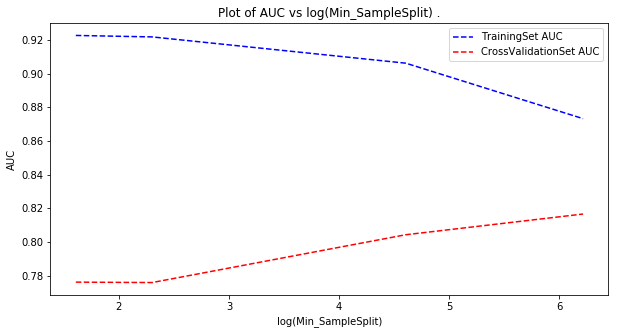

Starttime is : 2019-02-01 22:12:15.282161
Endtime   is : 2019-02-01 22:12:45.676679


In [70]:
import matplotlib.pyplot as plt
# plot inline
%matplotlib inline  

# Import the DecisionTreeClassifier .
from sklearn import tree
# Import the metrics module.
from sklearn.metrics import roc_auc_score

# Set the start time of the current cell run.
starttime_dt_avgw2v = datetime.datetime.now()

# Set the range for the hyper-parameters.
# Experiment with min_sample_split ranges in [5, 10,100,500].
# Here min_samples_split is the other hyper-parameter of the DecisionTreeClassifier

hp_min_samples_split = [5, 10, 100, 500]

# Use the cross-validation dataset to determine the best hyper-parameter min_sample_split.
plot_X_train = []
plot_lgX_train = []
plot_Y_train = []
plot_Y_cv = []

# Loop through various values of min_samples_split.
for i in hp_min_samples_split:
    dt_optimal = _
    tree.DecisionTreeClassifier(criterion='gini',          # metric to measure quality of the split.
                                splitter = 'best',         # strategy used to split at each node.
                                max_depth=(10),  # Hyper-parameter, "Depth" of the current iteration.
                                min_samples_split = (i), # Hyper-parameter, 
                                                         # "minimum sample split" of the 
                                                         # current iteration.
                                class_weight='balanced') # uses the values of y to automatically 
                                                         # adjust weights in the input data.

    dt_optimal.fit(X_train_stdzd, Y_train)  # fit the model on the training set.
    Y_pred_train = dt_optimal.predict_proba(X_train_stdzd)[:, 1] # predict class probabilities in training set.    
    Y_pred_cv = dt_optimal.predict_proba(X_cv_stdzd)[:, 1]       # predict class probabilities in CV set.

    # Compute AuC metric.
    plot_X_train.append(i)           # plot (min_sample_split) on the x-axis.
    plot_lgX_train.append(np.log(i)) # plot log(min_sample_split) on the x-axis.
    # TrainingSet
    plot_Y_train.append(roc_auc_score(Y_train,Y_pred_train)) # plot trainingset auc score on the y-axis.
    # CV set
    plot_Y_cv.append(roc_auc_score(Y_cv,Y_pred_cv))          # plot cvset auc score on the y-axis.



# print X,Y
print("Min_SampleSplit :\n{}".format(plot_X_train))
print("\nLog of Min_SampleSplit :\n{}".format(plot_lgX_train))
print("\nTrainingSet AuC :\n{}".format(plot_Y_train))
print("\nCVset AuC :\n{}".format(plot_Y_cv))

print("\nPlot of AuC vs Log of Min_SampleSplit:")
# Plot X-axis = log(Min_SampleSplit),Y-axis = TrainingSet and CVSet AuC to determine
# the best hyper-parameter.
plt.figure(figsize=(10,5))  # set the figure size.
plt.plot(plot_lgX_train,plot_Y_train, 'b--',label="TrainingSet AUC") # plotting Min_SampleSplit,trainingAuC
                                                                     # separately. 
plt.plot(plot_lgX_train,plot_Y_cv, 'r--',label="CrossValidationSet AUC") # plotting Min_SampleSplit,
                                                                         # CrossValidationAuC separately. 

plt.title("Plot of AUC vs log(Min_SampleSplit) .")  # Set the title of the plot.
plt.xlabel("log(Min_SampleSplit)")                  # Set the x label of the plot.
plt.ylabel("AUC")                                   # Set the y label of the plot.

# Display the plot.
plt.legend()                              # set the legend
plt.show()                                # display the plot.

# Set the end time of the current cell run.
endtime_dt_avgw2v = datetime.datetime.now()

# Print the cell run duration.
print("Starttime is : {}".format(starttime_dt_avgw2v))
print("Endtime   is : {}".format(endtime_dt_avgw2v))


#### NOTE :
    . If the training score and the validation score are both low, the classifier is underfitting. 
    . If the training score is high and the validation score is low, the classifier is overfitting.
    . Otherwise it is working very well. 

#### OBSERVATION :  When the min_sample_split = 500, then training AUC is low and cross-validation AUC is high. At this point the model neither Overfits nor Underfits.
#### The optimal hyper-parameter Min_Sample_Split choosen is shown below :
    . Min_Sample_Split = 500
    . Training AUC Score = 0.8732
    . CV AUC Score = 0.8166


#### [5.3.9] : Train and Fit the DecisionTree classifier in the training set. Compute the performance metrics by predicting the model on the test set.

In [71]:
# Import the DecisionTreeClassifier.
from sklearn import tree

# Set the start time of the current cell run.
starttime_dt_avgw2v = datetime.datetime.now()

# The best value of the hyper-parameter depth-tree.
optimal_depthtree = 10

# The best value of the hyper-parameter minimum_samplesplit.
optimal_minsamplesplit = 500

# Instantiate the DecisionTree model with optimal hyper-paramters.
dt_optimal = _
tree.DecisionTreeClassifier(criterion='gini',        # metric to measure quality of the split.
                            splitter = 'best',       # strategy used to split at each node.
                            max_depth=(optimal_depthtree), # Hyper-parameter, "Depth" of the
                                                           # current iteration.
                            min_samples_split = (optimal_minsamplesplit), # Hyper-parameter, 
                                                                          # "minimum sample split" 
                                                                          # of the current iteration.
                            class_weight='balanced') # uses the values of y to automatically 
                                                     # adjust weights in the input data.

dt_optimal.fit(X_train_stdzd, Y_train)  # fit the model on the training set.
Y_pred_test = dt_optimal.predict(X_test_stdzd)  # predict,response from the DecisionTree model.
Y_pred_train_pb = dt_optimal.predict_proba(X_train_stdzd)[:, 1] # predict class probabilities on the trainset.
Y_pred_cv_pb = dt_optimal.predict_proba(X_cv_stdzd)[:, 1]  # predict class probabilities on the cvset.
Y_pred_test_pb = dt_optimal.predict_proba(X_test_stdzd)[:, 1] # predict class probabilities on the testset.

# Set the end time of the current cell run.
endtime_dt_avgw2v = datetime.datetime.now()

# Print the cell run duration.
print("Starttime is : {}".format(starttime_dt_avgw2v))
print("Endtime   is : {}".format(endtime_dt_avgw2v))

Starttime is : 2019-02-01 22:14:21.019484
Endtime   is : 2019-02-01 22:14:27.925795


#### [5.3.10] : Plot the ROC Curve.

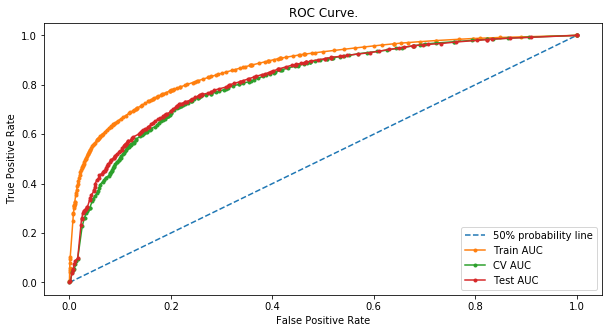

In [72]:
# Import the modules
from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt

# Calculate the RoC curve
fprTest, tprTest, thresholdsTest = roc_curve(Y_test,Y_pred_test_pb,pos_label=1) # compute the test roc curve.
fprCV, tprCV, thresholdsCV = roc_curve(Y_cv,Y_pred_cv_pb,pos_label=1)           # compute the cv roc curve.
fprTrain, tprTrain, thresholdsTrain = roc_curve(Y_train,Y_pred_train_pb,pos_label=1) # compute the train roc curve.

plt.figure(figsize=(10,5))                                            # set the figure size.
plt.plot([0, 1], [0, 1], linestyle='--',label="50% probability line") # plot the 50% probability line.
plt.plot(fprTrain, tprTrain, marker='.',label="Train AUC")            # plot the train roc curve for the model.
plt.plot(fprCV, tprCV, marker='.',label="CV AUC")                     # plot the cv roc curve for the model.
plt.plot(fprTest, tprTest, marker='.',label="Test AUC")               # plot the test roc curve for the model.
plt.title("ROC Curve.")                                               # set the title of the plot.
plt.xlabel("False Positive Rate")                                     # set the x label of the plot.
plt.ylabel("True Positive Rate")                                      # set the y label of the plot.
plt.legend()                                                          # set the legend
plt.show()                                                            # show the plot.

#### [5.3.11] Plot the classifier performance metrics.

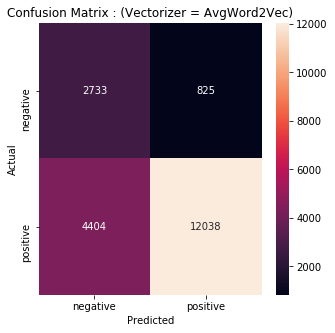


The class composition in the testset is :
1    16442
0     3558
Name: Comment, dtype: int64


In [73]:
# evaluate the model and report the metrics.
from sklearn.metrics import confusion_matrix
conf_mat = confusion_matrix(Y_test, Y_pred_test)
fig, ax = plt.subplots(figsize=(5,5))
sns.heatmap(conf_mat, annot=True, fmt='d'
            ,xticklabels=['negative','positive'], yticklabels=['negative','positive'])
plt.title('Confusion Matrix : (Vectorizer = AvgWord2Vec)')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

#Class composition in the testset.
dfYTest = pd.DataFrame(list(Y_test),columns=['Comment'])
print("\nThe class composition in the testset is :")
print(dfYTest["Comment"].value_counts())

#### [5.3.12] : Load metrics into the summary table for AvgWord2Vec.

In [74]:
# Import the metrics module.
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score

# Add the classification metrics to the summary table.
summaryTable.add_row(['AvgWord2Vec',optimal_depthtree,optimal_minsamplesplit,'Accuracy',accuracy_score(Y_test,Y_pred_test)])
summaryTable.add_row(['',optimal_depthtree,optimal_minsamplesplit,'Precision',precision_score(Y_test,Y_pred_test)])
summaryTable.add_row(['',optimal_depthtree,optimal_minsamplesplit,'Recall',recall_score(Y_test,Y_pred_test)])
summaryTable.add_row(['',optimal_depthtree,optimal_minsamplesplit,'F1 Score',f1_score(Y_test,Y_pred_test)])
summaryTable.add_row(['',optimal_depthtree,optimal_minsamplesplit,'AUC Score',roc_auc_score(Y_test,Y_pred_test_pb)])
summaryTable.add_row(['',optimal_depthtree,optimal_minsamplesplit,'ConfusionMatrix',confusion_matrix(Y_test, Y_pred_test)])
summaryTable.add_row(['----------','----------','-----------','----------','----------'])


## [5.4] Applying Decision Trees on TFIDF W2V,<font color='red'> SET 4</font>

#### [5.4.1] Convert review text into numeric vectors using TF-IDF_WW2F

In [76]:
#TF-IDF
# Apply TF-IDF vectorization only on the trainingset.
tf_idf_vect = TfidfVectorizer(dtype='float64',ngram_range=(1,2))

#Train you tf-idf vectorizer on the train data.
final_tf_idf = tf_idf_vect.fit_transform(X_train.values.astype('U'))

#Print the details.
print("the type of count vectorizer ",type(final_tf_idf))
print("the shape of out text TFIDF vectorizer ",final_tf_idf.get_shape())
print("the number of unique words including both unigrams and bigrams ", final_tf_idf.get_shape()[1])

the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text TFIDF vectorizer  (60000, 1192587)
the number of unique words including both unigrams and bigrams  1192587


#### [5.4.2] Use the TF-IDF vectorizer trained in the preceding step to convert cross-validation and test set to vectors.

In [77]:
#use the same countvectorizer on the cross-validation set.
final_tf_idf_cvset = tf_idf_vect.transform(X_cv.values)

#Print the details.
print("the type of count vectorizer ",type(final_tf_idf_cvset))
print("the shape of out text TF-IDF vectorizer ",final_tf_idf_cvset.get_shape())
print("the number of unique words ", final_tf_idf_cvset.get_shape()[1])

#use the same countvectorizer on the test set.
final_tf_idf_testset = tf_idf_vect.transform(X_test.values)

#Print the details.
print("the type of count vectorizer ",type(final_tf_idf_testset))
print("the shape of out text TF-IDF vectorizer ",final_tf_idf_testset.get_shape())
print("the number of unique words ", final_tf_idf_testset.get_shape()[1])

# we are converting a dictionary with word as a key, and the idf as a value
dictionary = dict(zip(tf_idf_vect.get_feature_names(), list(tf_idf_vect.idf_)))


the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text TF-IDF vectorizer  (20000, 1192587)
the number of unique words  1192587
the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text TF-IDF vectorizer  (20000, 1192587)
the number of unique words  1192587


#### [5.4.3] Build the list of sentences for the training,crossvalidation and test set respectively.

In [78]:
# Build the list of sentences from the training set.
list_of_sent=[]                           # List to store the sentences from the Review comments.
for sent in X_train.values.astype('U'):   # Loop through the Review comments, one at a time.
    list_of_sent.append(sent.split())     # Split the Review comments into sentences and store 
                                          # them in the List.

# Build the list of sentences from the cross-validation set.
list_of_sent_cv=[]                          # List to store the sentences from the Review comments.
for sent in X_cv.values:                    # Loop through the Review comments, one at a time.
    list_of_sent_cv.append(sent.split())    # Split the Review comments into sentences and store them
                                            # in the List.

# Build the list of sentences from the test set.
list_of_sent_test=[]                        # List to store the sentences from the Review comments.
for sent in X_test.values:                  # Loop through the Review comments, one at a time.
    list_of_sent_test.append(sent.split())  # Split the Review comments into sentences and store 
                                            # them in the List.

#### [5.4.4] Train the Word2Vec model on the training set alone.

In [79]:
# min_count = 5 considers only words that occured atleast 5 times
# Word2Vec Syntax : Word2Vec(list,word_repeat_count,dimension_of_each_word_vector,Number_of_Processor_cores)

# Instantiate the Word2Vec vectorizer.
w2v_model=Word2Vec(list_of_sent,min_count=5,size=50, workers=4)
# Get the vocabulary. 
w2v_words = list(w2v_model.wv.vocab)
# Print the details.
print("number of words that occured minimum 5 times ",len(w2v_words))
print("sample words ", w2v_words[0:50])

number of words that occured minimum 5 times  15844
sample words  ['big', 'lover', 'fig', 'jam', 'unique', 'flavor', 'kind', 'mix', 'light', 'figs', 'dark', 'mission', 'must', 'great', 'product', 'good', 'price', 'definitely', 'ordering', 'used', 'bottles', 'ordered', 'expected', 'box', 'full', 'fortune', 'cookies', 'like', 'one', 'nonetheless', 'got', 'small', 'tasted', 'weird', 'okay', 'not', 'best', 'reviewing', 'review', 'amazon', 'checked', 'label', 'container', 'sure', 'enough', 'contains', 'propylene', 'glycol', 'top', 'ingredients']


#### [5.4.5] Train the TF-IDF Weighted Word2Vec on the training set.

In [80]:
# TF-IDF weighted Word2Vec
tfidf_feat = tf_idf_vect.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

tfidf_sent_vectors = [];              # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in tqdm(list_of_sent):       # for each review/sentence
    sent_vec = np.zeros(50)           # as word vectors are of zero length
    weight_sum =0;                    # num of words with a valid vector in the sentence/review
    for word in sent:                 # for each word in a review/sentence
        #print(word)
        if word in w2v_words:
            vec = w2v_model.wv[word]  # Vector representation of the word.
            
            # dictionary[word] = idf value of word in whole corpus
            # sent.count(word) = tf values of word in this review
            tfidf_avgw2v = dictionary[word]*(sent.count(word)/len(sent))   # Compute the weights for
                                                                           # Weighted Average.
            
            # Avg. Word2Vec = ((W2V(v1)*w1)+(W2V(v2)*w2)+(W2V(v3)*w3)+...... +(W2V(v364171)*w364171) / 
            #                  Sum(w1,w2,..w364171)            
            sent_vec += (vec * tfidf_avgw2v)  # Compute the numerator part of the above formula.
            weight_sum += tfidf_avgw2v        # Compute the denominator part of the above formula.
            
    if weight_sum != 0:
        sent_vec /= weight_sum                # Numerator/Denominator to get the Weighted Average.
    tfidf_sent_vectors.append(sent_vec)       # Add this to the List.
    row += 1


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 60000/60000 [04:23<00:00, 241.45it/s]


#### [5.4.6] Use the TF-IDF Weigthed Word2Vec model trained on training set to Cross-Validation set.

In [81]:
# TF-IDF weighted Word2Vec
tfidf_feat = tf_idf_vect.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

tfidf_sent_vectors_cv = [];              # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in tqdm(list_of_sent_cv):    # for each review/sentence 
    sent_vec = np.zeros(50)           # as word vectors are of zero length
    weight_sum =0;                    # num of words with a valid vector in the sentence/review
    for word in sent:                 # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]  # Vector representation of the word.
            
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf values of word in this review
            tfidf_avgw2v = dictionary[word]*(sent.count(word)/len(sent))   # Compute the weights for
                                                                           # Weighted Average.
            
            # Avg. Word2Vec = ((W2V(v1)*w1)+(W2V(v2)*w2)+(W2V(v3)*w3)+...... +(W2V(v364171)*w364171) /
            #                  Sum(w1,w2,..w364171)            
            sent_vec += (vec * tfidf_avgw2v)  # Compute the numerator part of the above formula.
            weight_sum += tfidf_avgw2v        # Compute the denominator part of the above formula.
            
    if weight_sum != 0:
        sent_vec /= weight_sum                # Numerator/Denominator to get the Weighted Average.
    tfidf_sent_vectors_cv.append(sent_vec)    # Add this to the List.
    row += 1

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20000/20000 [01:31<00:00, 219.63it/s]


#### [5.4.7] Use the TF-IDF Weigthed Word2Vec model trained on training set to Test set.

In [82]:
# TF-IDF weighted Word2Vec
tfidf_feat = tf_idf_vect.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

tfidf_sent_vectors_test = [];              # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in tqdm(list_of_sent_test):  # for each review/sentence 
    sent_vec = np.zeros(50)           # as word vectors are of zero length
    weight_sum =0;                    # num of words with a valid vector in the sentence/review
    for word in sent:                 # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]  # Vector representation of the word.
            
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf values of word in this review
            tfidf_avgw2v = dictionary[word]*(sent.count(word)/len(sent))   # Compute the weights for
                                                                           # Weighted Average.
            
            # Avg. Word2Vec = ((W2V(v1)*w1)+(W2V(v2)*w2)+(W2V(v3)*w3)+...... +(W2V(v364171)*w364171) / 
            #                   Sum(w1,w2,..w364171)            
            sent_vec += (vec * tfidf_avgw2v)  # Compute the numerator part of the above formula.
            weight_sum += tfidf_avgw2v        # Compute the denominator part of the above formula.
            
    if weight_sum != 0:
        sent_vec /= weight_sum                # Numerator/Denominator to get the Weighted Average.
    tfidf_sent_vectors_test.append(sent_vec)  # Add this to the List.
    row += 1

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20000/20000 [01:31<00:00, 218.38it/s]


#### [5.4.8] Standardize / Normalize the data

In [83]:
# Data-preprocessing: Normalizing the data
from sklearn.preprocessing import Normalizer

# Initialize the normalizer.
normalizer = Normalizer()

#Standardize on the train data.
X_train_stdzd = normalizer.fit_transform(tfidf_sent_vectors)

#Standardize the cv and test data.
X_cv_stdzd    = normalizer.transform(tfidf_sent_vectors_cv)    #use the same Normalizer on the cv set.
X_test_stdzd  = normalizer.transform(tfidf_sent_vectors_test)  #use the same Normalizer on the test set.

#### [5.4.9] Hyper-Parameter Tuning : Using the cross-validation dataset to calculate the optimal 'depth of tree' in TFIDF_AvgWord2Vec case.

Depth :
[1, 5, 10, 50, 100, 500]

Log of Depth :
[0.0, 1.6094379124341003, 2.302585092994046, 3.912023005428146, 4.605170185988092, 6.214608098422191]

TrainingSet AuC :
[0.6141442344211706, 0.791568879587354, 0.8488437533452087, 0.857069483017327, 0.8570075229576395, 0.8570075229576395]

CVset AuC :
[0.6038093148052082, 0.7619463654779124, 0.7829862392068864, 0.7794979130458061, 0.7797686092369255, 0.7795151141879345]

Plot of AuC vs Log of Depth:


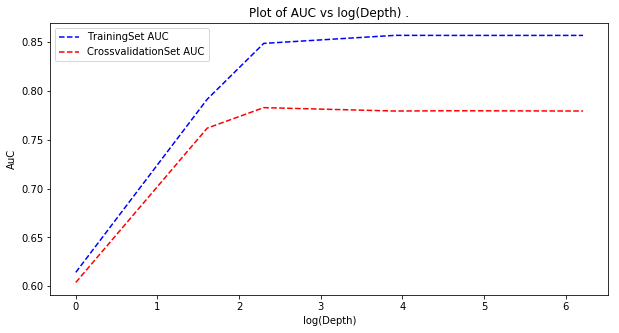

Starttime is : 2019-02-01 22:25:44.386172
Endtime   is : 2019-02-01 22:26:25.518635


In [84]:
import matplotlib.pyplot as plt
# plot inline
%matplotlib inline  

# Import the DecisionTreeClassifier .
from sklearn import tree
# Import the metrics module.
from sklearn.metrics import roc_auc_score

# Set the start time of the current cell run.
starttime_dt_tfidf_avgw2v = datetime.datetime.now()

# Set the range for the hyper-parameters.
# Experiment with depth ranges in [1, 5, 10, 50, 100, 500, 100].
# Here depth (tree-depth) is the hyper-parameter of the DecisionTreeClassifier

hp_depth = [1, 5, 10, 50, 100, 500]

# Use the cross-validation dataset to determine the best hyper-parameter depth (tree-depth).
plot_X_train = []
plot_lgX_train = []
plot_Y_train = []
plot_Y_cv = []

# Loop through various values of depth.
for i in hp_depth:
    dt_optimal = _
    tree.DecisionTreeClassifier(criterion='gini',          # metric to measure quality of the split.
                                splitter = 'best',         # strategy used to split at each node.
                                max_depth=(i),             # Hyper-parameter, "Depth" of the current iteration.
                                min_samples_split = (500), # Hyper-parameter, "minimum sample split" of the 
                                                           # current iteration.
                                class_weight='balanced')   # uses the values of y to automatically 
                                                           # adjust weights in the input data.

    dt_optimal.fit(X_train_stdzd, Y_train)                       # fit the model on the training set.
    Y_pred_train = dt_optimal.predict_proba(X_train_stdzd)[:, 1] # predict class probabilities in training set.    
    Y_pred_cv = dt_optimal.predict_proba(X_cv_stdzd)[:, 1]       # predict class probabilities in CV set.

    # Compute AuC metric.
    plot_X_train.append(i)                                  # plot (depth,min_sample_split) on the x-axis.
    plot_lgX_train.append(np.log(i))                        # plot log(depth,min_sample_split) on the x-axis.
    # TrainingSet
    plot_Y_train.append(roc_auc_score(Y_train,Y_pred_train)) # plot trainingset auc score on the y-axis.
    # CV set
    plot_Y_cv.append(roc_auc_score(Y_cv,Y_pred_cv))          # plot cvset auc score on the y-axis.



# print X,Y
print("Depth :\n{}".format(plot_X_train))
print("\nLog of Depth :\n{}".format(plot_lgX_train))
print("\nTrainingSet AuC :\n{}".format(plot_Y_train))
print("\nCVset AuC :\n{}".format(plot_Y_cv))

print("\nPlot of AuC vs Log of Depth:")
# Plot X-axis = log(Depth),Y-axis = TrainingSet and CVSet AuC to determine the best hyper-parameter combo.
plt.figure(figsize=(10,5))                                                 # set the figure size.
plt.plot(plot_lgX_train,plot_Y_train, 'b--',label="TrainingSet AUC")       # plotting depth,trainingAuC 
                                                                           # separately. 
plt.plot(plot_lgX_train,plot_Y_cv, 'r--',label="CrossvalidationSet AUC")   # plotting depth,CrossValidationAuC
                                                                           # separately. 

plt.title("Plot of AUC vs log(Depth) .")  # Set the title of the plot.
plt.xlabel("log(Depth)")                  # Set the x label of the plot.
plt.ylabel("AuC")                         # Set the y label of the plot.

# Display the plot.
plt.legend()                              # set the legend
plt.show()                                # display the plot.

# Set the end time of the current cell run.
endtime_dt_tfidf_avgw2v = datetime.datetime.now()

# Print the cell run duration.
print("Starttime is : {}".format(starttime_dt_tfidf_avgw2v))
print("Endtime   is : {}".format(endtime_dt_tfidf_avgw2v))


#### NOTE :
    . If the training score and the validation score are both low, the classifier is underfitting. 
    . If the training score is high and the validation score is low, the classifier is overfitting.
    . Otherwise it is working very well. 


#### OBSERVATION :  When the tree depth = 10, then training and cross-validation AUC is high, beyond which the training AuC continues to increase while the cross-validation AuC decreases. At tree depth = 10, the model neither Overfits nor Underfits.
#### The optimal hyper-parameter, Depth choosen is shown below :
    . Depth of tree = 10
    . Training AUC Score = 0.8488
    . CrossValidation AUC Score = 0.7829


#### [5.4.10] Hyper-Parameter Tuning : Using the cross-validation dataset to calculate the optimal 'min_sample_split' in AvgWord2Vec case.

Min_SampleSplit :
[5, 10, 100, 500]

Log of Min_SampleSplit :
[1.6094379124341003, 2.302585092994046, 4.605170185988092, 6.214608098422191]

TrainingSet AuC :
[0.9021620729288069, 0.900902355365864, 0.8843504333610055, 0.8488437533452087]

CVset AuC :
[0.7531762895184613, 0.7523385499680086, 0.7743008166399422, 0.7829862392068864]

Plot of AuC vs Log of Min_SampleSplit:


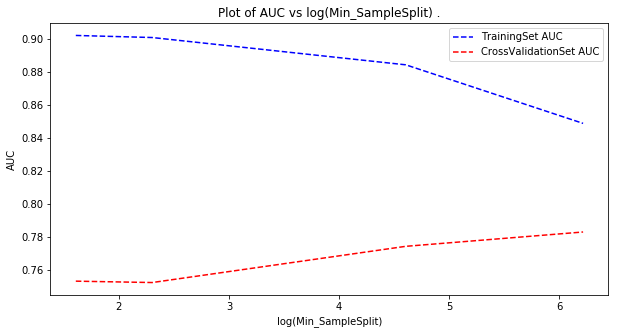

Starttime is : 2019-02-01 22:31:59.099437
Endtime   is : 2019-02-01 22:32:29.679421


In [85]:
import matplotlib.pyplot as plt
# plot inline
%matplotlib inline  

# Import the DecisionTreeClassifier .
from sklearn import tree
# Import the metrics module.
from sklearn.metrics import roc_auc_score

# Set the start time of the current cell run.
starttime_dt_tfidf_avgw2v = datetime.datetime.now()

# Set the range for the hyper-parameters.
# Experiment with min_sample_split ranges in [5, 10,100,500].
# Here min_samples_split is the other hyper-parameter of the DecisionTreeClassifier

hp_min_samples_split = [5, 10, 100, 500]

# Use the cross-validation dataset to determine the best hyper-parameter min_sample_split.
plot_X_train = []
plot_lgX_train = []
plot_Y_train = []
plot_Y_cv = []

# Loop through various values of min_samples_split.
for i in hp_min_samples_split:
    dt_optimal = _
    tree.DecisionTreeClassifier(criterion='gini',          # metric to measure quality of the split.
                                splitter = 'best',         # strategy used to split at each node.
                                max_depth=(10),            # Hyper-parameter, "Depth" of the current iteration.
                                min_samples_split = (i),   # Hyper-parameter, "minimum sample split" of the 
                                                           # current iteration.
                                class_weight='balanced')   # uses the values of y to automatically 
                                                           # adjust weights in the input data.

    dt_optimal.fit(X_train_stdzd, Y_train)                       # fit the model on the training set.
    Y_pred_train = dt_optimal.predict_proba(X_train_stdzd)[:, 1] # predict class probabilities in training set.    
    Y_pred_cv = dt_optimal.predict_proba(X_cv_stdzd)[:, 1]       # predict class probabilities in CV set.

    # Compute AuC metric.
    plot_X_train.append(i)                # plot (min_sample_split) on the x-axis.
    plot_lgX_train.append(np.log(i))      # plot log(min_sample_split) on the x-axis.
    # TrainingSet
    plot_Y_train.append(roc_auc_score(Y_train,Y_pred_train)) # plot trainingset auc score on the y-axis.
    # CV set
    plot_Y_cv.append(roc_auc_score(Y_cv,Y_pred_cv))          # plot cvset auc score on the y-axis.



# print X,Y
print("Min_SampleSplit :\n{}".format(plot_X_train))
print("\nLog of Min_SampleSplit :\n{}".format(plot_lgX_train))
print("\nTrainingSet AuC :\n{}".format(plot_Y_train))
print("\nCVset AuC :\n{}".format(plot_Y_cv))

print("\nPlot of AuC vs Log of Min_SampleSplit:")
# Plot X-axis = log(Min_SampleSplit),Y-axis = TrainingSet and CVSet AuC to determine the best hyper-parameter.
plt.figure(figsize=(10,5))                                                 # set the figure size.
plt.plot(plot_lgX_train,plot_Y_train, 'b--',label="TrainingSet AUC")       # plotting Min_SampleSplit,trainingAuC
                                                                           # separately. 
plt.plot(plot_lgX_train,plot_Y_cv, 'r--',label="CrossValidationSet AUC")   # plotting Min_SampleSplit,CrossValidationAuC
                                                                           # separately. 

plt.title("Plot of AUC vs log(Min_SampleSplit) .")  # Set the title of the plot.
plt.xlabel("log(Min_SampleSplit)")                  # Set the x label of the plot.
plt.ylabel("AUC")                                   # Set the y label of the plot.

# Display the plot.
plt.legend()                              # set the legend
plt.show()                                # display the plot.

# Set the end time of the current cell run.
endtime_dt_tfidf_avgw2v = datetime.datetime.now()

# Print the cell run duration.
print("Starttime is : {}".format(starttime_dt_tfidf_avgw2v))
print("Endtime   is : {}".format(endtime_dt_tfidf_avgw2v))


#### NOTE :
    . If the training score and the validation score are both low, the classifier is underfitting. 
    . If the training score is high and the validation score is low, the classifier is overfitting.
    . Otherwise it is working very well. 

#### OBSERVATION :  When the min_sample_split = 500, then training AUC is low and cross-validation AUC is high. At this point the model neither Overfits nor Underfits.
#### The optimal hyper-parameter Min_Sample_Split choosen is shown below :
    . Min_Sample_Split = 500
    . Training AUC Score = 0.8488
    . CV AUC Score = 0.7829


#### [5.4.11] : Train and Fit the DecisionTree classifier in the training set. Compute the performance metrics by predicting the model on the test set.

In [86]:
# Import the DecisionTreeClassifier.
from sklearn import tree

# Set the start time of the current cell run.
starttime_dt_tfidf_avgw2v = datetime.datetime.now()

# The best value of the hyper-parameter depth-tree.
optimal_depthtree = 10

# The best value of the hyper-parameter minimum_samplesplit.
optimal_minsamplesplit = 500

# Instantiate the DecisionTree model with optimal hyper-paramters.
dt_optimal = _
tree.DecisionTreeClassifier(criterion='gini',        # metric to measure quality of the split.
                            splitter = 'best',       # strategy used to split at each node.
                            max_depth=(optimal_depthtree), # Hyper-parameter, "Depth" of the current
                                                           # iteration.
                            min_samples_split = (optimal_minsamplesplit), # Hyper-parameter, 
                                                                          # "minimum sample split" 
                                                                         # of the current iteration.
                            class_weight='balanced') # uses the values of y to automatically 
                                                     # adjust weights in the input data.

dt_optimal.fit(X_train_stdzd, Y_train)  # fit the model on the training set.
Y_pred_test = dt_optimal.predict(X_test_stdzd)  # predict,response from the DecisionTree model.
Y_pred_train_pb = dt_optimal.predict_proba(X_train_stdzd)[:, 1]# predict class probabilities on the trainset.
Y_pred_cv_pb = dt_optimal.predict_proba(X_cv_stdzd)[:, 1]  # predict class probabilities on the cvset.
Y_pred_test_pb = dt_optimal.predict_proba(X_test_stdzd)[:, 1] # predict class probabilities on the testset.

# Set the end time of the current cell run.
endtime_dt_tfidf_avgw2v = datetime.datetime.now()

# Print the cell run duration.
print("Starttime is : {}".format(starttime_dt_tfidf_avgw2v))
print("Endtime   is : {}".format(endtime_dt_tfidf_avgw2v))

Starttime is : 2019-02-01 22:33:46.353362
Endtime   is : 2019-02-01 22:33:53.336171


#### [5.4.12] : Plot the ROC Curve.

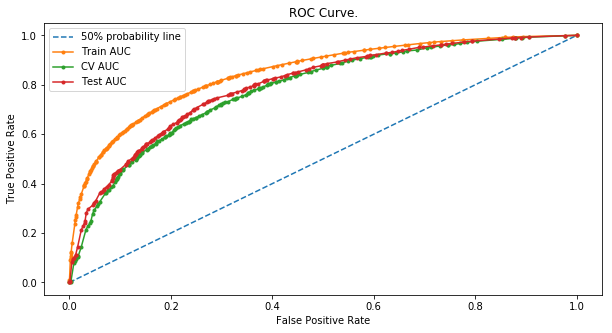

In [87]:
# Import the modules
from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt

# Calculate the RoC curve
fprTest, tprTest, thresholdsTest = roc_curve(Y_test,Y_pred_test_pb,pos_label=1) # compute the test roc curve.
fprCV, tprCV, thresholdsCV = roc_curve(Y_cv,Y_pred_cv_pb,pos_label=1)           # compute the cv roc curve.
fprTrain, tprTrain, thresholdsTrain = roc_curve(Y_train,Y_pred_train_pb,pos_label=1) # compute the train roc
                                                                                     # curve.

plt.figure(figsize=(10,5))                                               # set the figure size.
plt.plot([0, 1], [0, 1], linestyle='--',label="50% probability line")    # plot the 50% probability line.
plt.plot(fprTrain, tprTrain, marker='.',label="Train AUC")      # plot the train roc curve for the model.
plt.plot(fprCV, tprCV, marker='.',label="CV AUC")               # plot the cv roc curve for the model.
plt.plot(fprTest, tprTest, marker='.',label="Test AUC")         # plot the test roc curve for the model.
plt.title("ROC Curve.")                                                  # set the title of the plot.
plt.xlabel("False Positive Rate")                                        # set the x label of the plot.
plt.ylabel("True Positive Rate")                                         # set the y label of the plot.
plt.legend()                                                             # set the legend
plt.show()                                                               # show the plot.

#### [5.4.12] Plot the classifier performance metrics.

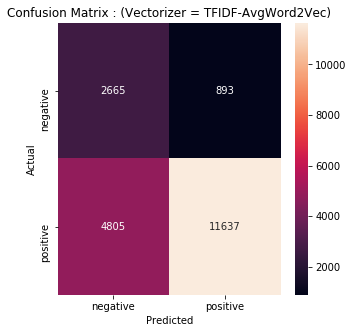


The class composition in the testset is :
1    16442
0     3558
Name: Comment, dtype: int64


In [88]:
# evaluate the model and report the metrics.
from sklearn.metrics import confusion_matrix
conf_mat = confusion_matrix(Y_test, Y_pred_test)
fig, ax = plt.subplots(figsize=(5,5))
sns.heatmap(conf_mat, annot=True, fmt='d'
            ,xticklabels=['negative','positive'], yticklabels=['negative','positive'])
plt.title('Confusion Matrix : (Vectorizer = TFIDF-AvgWord2Vec)')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

#Class composition in the testset.
dfYTest = pd.DataFrame(list(Y_test),columns=['Comment'])
print("\nThe class composition in the testset is :")
print(dfYTest["Comment"].value_counts())

#### [5.4.14] : Load metrics into the summary table for TFIDF-AvgWord2Vec.

In [99]:
# Import the metrics module.
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score

# Add the classification metrics to the summary table.
summaryTable.add_row(['TFIDF-AvgWord2Vec',optimal_depthtree,optimal_minsamplesplit,'Accuracy',accuracy_score(Y_test,Y_pred_test)])
summaryTable.add_row(['',optimal_depthtree,optimal_minsamplesplit,'Precision',precision_score(Y_test,Y_pred_test)])
summaryTable.add_row(['',optimal_depthtree,optimal_minsamplesplit,'Recall',recall_score(Y_test,Y_pred_test)])
summaryTable.add_row(['',optimal_depthtree,optimal_minsamplesplit,'F1 Score',f1_score(Y_test,Y_pred_test)])
summaryTable.add_row(['',optimal_depthtree,optimal_minsamplesplit,'AUC Score',roc_auc_score(Y_test,Y_pred_test_pb)])
summaryTable.add_row(['',optimal_depthtree,optimal_minsamplesplit,'ConfusionMatrix',confusion_matrix(Y_test, Y_pred_test)])
summaryTable.add_row(['----------','----------','-----------','----------','----------'])


# [6] Conclusions

In [1]:
from IPython.display import Image 

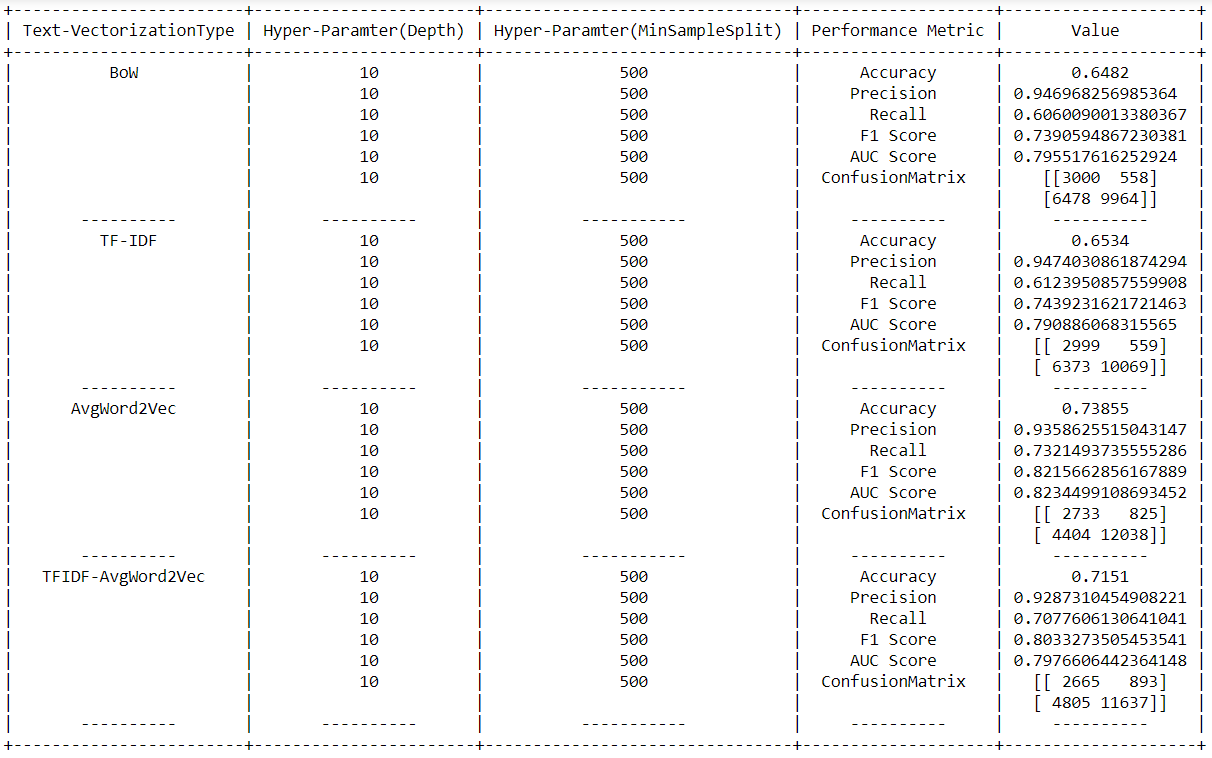

In [2]:
Image(filename='D:\Plot\SummaryTable_DecisionTree.PNG')

#### Based on the above table, the vectorizer that is found to be optimal is AverageWord2Vec, since its AUC is maximum relative to the other vectorizers and its FalsePositives and FalseNegatives in the confusion matrix is better when compared to the other vectorizers.